In [1]:
import os
import sys
import socket
import pickle
import importlib
import itertools
import functools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import xgboost as xgb

from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV

# Figure out local paths
SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import utils
import seq

COVID_DIR = os.path.join(os.path.dirname(SRC_DIR), "covid19")
assert os.path.isdir(COVID_DIR)
sys.path.append(COVID_DIR)
import covid19

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)
plt.style.use(['default', os.path.join(SRC_DIR, 'seaborn-paper-custom.mplstyle')])

np.random.seed(27492)
SEED = 27492

print('The scikit-learn version is {}.'.format(sklearn.__version__))
K_FOLD = 5

INFO:root:CPU


The scikit-learn version is 0.21.3.


In [2]:
importlib.reload(data_loader)
orig_full_dataset = data_loader.LocalizationClassificationKmers("all", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 1223/3660 = 0.3341530054644809 positive
INFO:root:Lma - 768/3660 = 0.2098360655737705 positive
INFO:root:Mito - 301/3660 = 0.08224043715846995 positive
INFO:root:Nes - 208/3660 = 0.05683060109289618 positive
INFO:root:Nik - 1371/3660 = 0.37459016393442623 positive
INFO:root:Nls - 823/3660 = 0.22486338797814207 positive
INFO:root:NucPore - 159/3660 = 0.04344262295081967 positive
INFO:root:Omm - 739/3660 = 0.20191256830601093 positive
INFO:root:3245	0.8866120218579235	protein_coding
INFO:root:100	0.0273224043715847	lincRNA
INFO:root:97	0.026502732240437157	antisense_RNA
INFO:root:49	0.013387978142076503	transcribed_unprocessed_pseudogene
INFO:root:49	0.013387978142076503	processed_pseudogene
INFO:root:28	0.007650273224043716	processed_transcript


In [3]:
orig_full_dataset.truth_matrix.sum(axis=0)

array([1223,  768,  301,  208, 1371,  823,  159,  739])

In [4]:
mito_logfc_percentiles = np.percentile(orig_full_dataset.log2fc_matrix[np.where(orig_full_dataset.truth_matrix[:, 2]), 2], [20, 33, 50])
mito_logfc_percentiles

array([1.08531567, 1.32577347, 1.5760813 ])

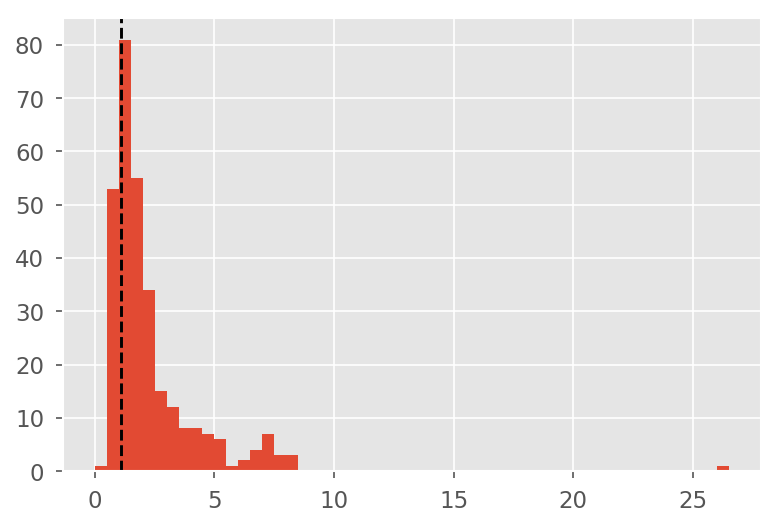

In [5]:
fig, ax = plt.subplots(dpi=150)
hist_bins = np.arange(0, 27, 0.5)
ax.hist(orig_full_dataset.log2fc_matrix[np.where(orig_full_dataset.truth_matrix[:, 2]), 2].flatten(), bins=hist_bins)
ax.axvline(mito_logfc_percentiles[0], linestyle='--', color='black')
fig.show()

In [13]:
importlib.reload(data_loader)
train_dataset = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False, drop_mito=True)
valid_dataset = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False, drop_mito=True)
test_dataset = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False, drop_mito=True)
full_dataset = data_loader.LocalizationClassificationKmers("all", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False, drop_mito=True)
train_data = data_loader.load_data_as_np(train_dataset)
valid_data = data_loader.load_data_as_np(valid_dataset)
test_data = data_loader.load_data_as_np(test_dataset)
full_data = data_loader.load_data_as_np(full_dataset)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Dropping 61 genes for low positive mito label
INFO:root:Erm - 980/2879 = 0.3403959708232025 positive
INFO:root:Lma - 602/2879 = 0.2091003820771101 positive
INFO:root:Mito - 200/2879 = 0.06946856547412296 positive
INFO:root:Nes - 166/2879 = 0.05765890934352206 positive
INFO:root:Nik - 1083/2879 = 0.37617228204237585 positive
INFO:root:Nls - 666/2879 = 0.23133032302882944 positive
INFO:root:NucPore - 125/2879 = 0.04341785342132685 positive
INFO:root:Omm - 585/2879 = 0.20319555401180966 positive
INFO:root:2546	0.8843348384855853	protein_coding
INFO:root:84	0.029176797499131643	lincRNA
INFO:root:80	0.027787426189649182	antisense_RNA
INFO:root:38	0.013199027440083362	transcribed_unprocessed_pseudogene
INFO:root:37	0.012851684612712747	processed_pseudogene

In [14]:
full_data[0].shape, full_data[1].shape

((3599, 4032), (3599, 8))

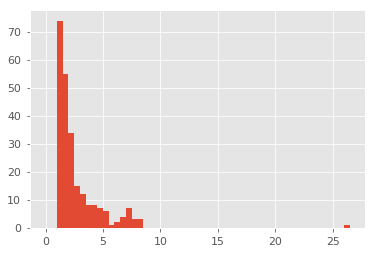

In [15]:
fig, ax = plt.subplots()
ax.hist(full_dataset.log2fc_matrix[np.where(full_data[1][:, 2]), 2].flatten(), bins=hist_bins)
fig.show()

In [16]:
full_data[1].sum(axis=0)

array([1221.,  764.,  240.,  204., 1363.,  816.,  155.,  731.],
      dtype=float32)

In [17]:
full_data[1].sum(axis=0) / full_data[1].shape[0]

array([0.3392609 , 0.21228118, 0.06668519, 0.05668241, 0.37871632,
       0.22672965, 0.04306752, 0.20311198], dtype=float32)

In [18]:
print(train_data[0].shape, train_data[1].shape)
print(valid_data[0].shape, valid_data[1].shape)
print(test_data[0].shape, test_data[1].shape)
print(full_data[0].shape, full_data[1].shape)

(2879, 4032) (2879, 8)
(360, 4032) (360, 8)
(360, 4032) (360, 8)
(3599, 4032) (3599, 8)


In [19]:
n_est, crit, depth, min_samp, max_feat, weight = (300, 'entropy', 100, 0.001, 'sqrt', None)
rf_param_dict = {
    "n_estimators": n_est,
    "criterion": crit,
    "max_depth": depth,
    "min_samples_leaf": min_samp,
    "max_features": max_feat,
    "class_weight": weight,
    "n_jobs": 64,
    "random_state": 39282,
}

rf_model, rf_per_class_perf, rf_overall_perf = model_utils.multi_train(
    RandomForestClassifier(**rf_param_dict),
    train_data,
    valid_data,
    verbose=False,
)
rf_overall_perf.auroc, rf_overall_perf.auprc

(0.7539919278859062, 0.4702883283129881)

In [20]:
[(p.auroc, p.auprc) for p in rf_per_class_perf]

[(0.7531914893617021, 0.6331747916871894),
 (0.7051889869949111, 0.47813995167338447),
 (0.7585319842222603, 0.45392724156978387),
 (0.8495138138601637, 0.34739332424063674),
 (0.665798611111111, 0.5800695587508318),
 (0.7809147117657756, 0.567710553113805),
 (0.6894157088122606, 0.10997394679962545),
 (0.8293801169590643, 0.5919172586686483)]

In [21]:
# Same as above, but for test set
importlib.reload(model_utils)
rf_test_prob_matrix = model_utils.list_preds_to_array_preds(rf_model.predict_proba(test_data[0]))
rf_test_per_class_perf = model_utils.generate_multiclass_perf(test_data[1], rf_test_prob_matrix, 8)
rf_test_overall_perf = model_utils.generate_model_perf(test_data[1], rf_test_prob_matrix, multiclass=True)

rf_test_overall_perf.auroc, rf_test_overall_perf.auprc

(0.7345532408941856, 0.45501067458201855)

In [22]:
[(p.auroc, p.auprc) for p in rf_test_per_class_perf]

[(0.7451420293951385, 0.5392701379447741),
 (0.7485472318572909, 0.5889050641451072),
 (0.6881047606760418, 0.3663410775448502),
 (0.7914801666923907, 0.3550294706078663),
 (0.691734506302521, 0.5692627171012904),
 (0.7546778549382716, 0.4953847467852557),
 (0.6647173489278753, 0.2045015149684871),
 (0.7920220283639554, 0.5213906675585175)]

In [23]:
# Accuracy based on validation cutoffs
valid_preds = model_utils.list_preds_to_array_preds(rf_model.predict_proba(valid_data[0]))
valid_youden_cutoffs = np.array([model_utils.youden_threshold(preds=valid_preds[:, i], truth=valid_data[1][:, i]) for i in range(8)])

test_probs = model_utils.list_preds_to_array_preds(rf_model.predict_proba(test_data[0]))
test_preds = np.array(test_probs > valid_youden_cutoffs).astype(int)
accuracies = np.array([metrics.accuracy_score(test_data[1][:, i], test_preds[:, i]) for i in range(8)])
accuracies

array([0.6       , 0.675     , 0.71111111, 0.77777778, 0.66111111,
       0.62222222, 0.75555556, 0.65833333])

In [24]:
valid_youden_cutoffs

array([0.29148942, 0.21244697, 0.0777393 , 0.0910968 , 0.38249988,
       0.20722739, 0.06228836, 0.22839851])

In [25]:
utils.save_sklearn_model(rf_model, os.path.join(os.path.dirname(SRC_DIR), 'models', f'rf_8way_mito_drop_fold{K_FOLD}'))

'/storage/wukevin/projects/rnagps/models/rf_8way_mito_drop_fold5.0.21.3.skmodel'

In [26]:
BASELINE_DIR = os.path.join(
    os.path.dirname(SRC_DIR),
    "covid19/baselines"
)
assert os.path.isdir(BASELINE_DIR)

In [27]:
np.savetxt(os.path.join(BASELINE_DIR, "baseline_human_apex_mito_drop.csv"), test_probs)
test_probs

array([[0.43039743, 0.23234933, 0.05068867, ..., 0.19985053, 0.02147908,
        0.20519701],
       [0.16875241, 0.30778564, 0.09107427, ..., 0.27294793, 0.04568105,
        0.05221032],
       [0.2050291 , 0.35371693, 0.03286376, ..., 0.25294577, 0.02426299,
        0.05726587],
       ...,
       [0.27207816, 0.15391823, 0.08407275, ..., 0.18639815, 0.03036376,
        0.11299868],
       [0.42632011, 0.13565079, 0.04999242, ..., 0.11077778, 0.01757804,
        0.16771693],
       [0.6451835 , 0.14582011, 0.05290344, ..., 0.07351852, 0.02703571,
        0.41654016]])

In [28]:
np.savetxt(os.path.join(BASELINE_DIR, "baseline_human_apex_labels_mito_drop.csv"), test_data[1])
test_data[1]

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [35]:
RNAGPS = utils.load_sklearn_model(os.path.join(os.path.dirname(SRC_DIR), 'models', "rf_8way_fold5.0.21.3.skmodel"))
test_probs_original = model_utils.list_preds_to_array_preds(RNAGPS.predict_proba(test_data[0]))
test_probs_original

array([[0.19515368, 0.684829  , 0.02246561, ..., 0.64758526, 0.02665608,
        0.06542063],
       [0.12100794, 0.25493519, 0.06486941, ..., 0.49380688, 0.05287169,
        0.03380159],
       [0.18492809, 0.40865091, 0.03825   , ..., 0.31464935, 0.02467208,
        0.05745726],
       ...,
       [0.26133201, 0.1585968 , 0.12821236, ..., 0.17831755, 0.05292352,
        0.11898437],
       [0.44194601, 0.15795238, 0.05218915, ..., 0.12297751, 0.02772511,
        0.14155892],
       [0.64179834, 0.16284524, 0.0547797 , ..., 0.09057937, 0.02604762,
        0.44651888]])

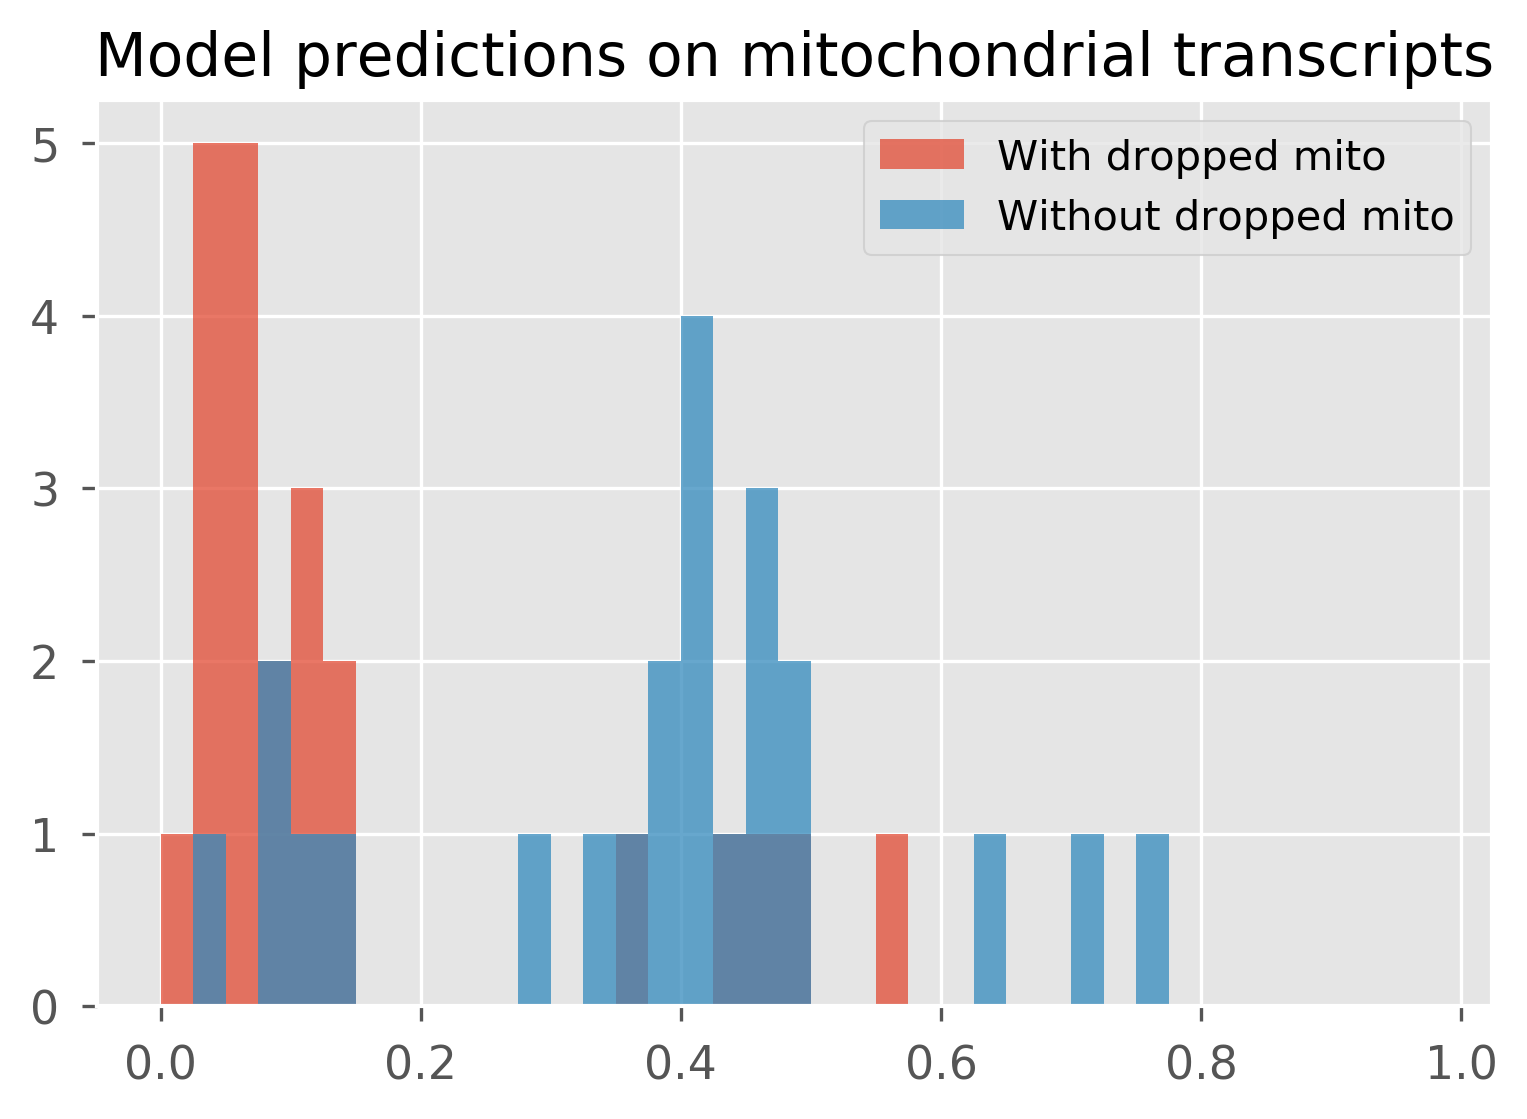

In [36]:
fig, ax = plt.subplots(dpi=300)
ax.hist(
    test_probs[np.where(test_data[1][:, 2]), 2].flatten(), 
    bins=np.arange(0., 1., 0.025),
    label="With dropped mito",
    alpha=0.75,
)
ax.hist(
    test_probs_original[np.where(test_data[1][:, 2]), 2].flatten(),
    bins=np.arange(0, 1, 0.025),
    label="Without dropped mito",
    alpha=0.75
)
ax.legend()
ax.set(
    title="Model predictions on mitochondrial transcripts",
)
fig.show()

## Plot predictions scatterplot

These are likely less informative because some test sequences were probably used in training/validation for RNA-GPS

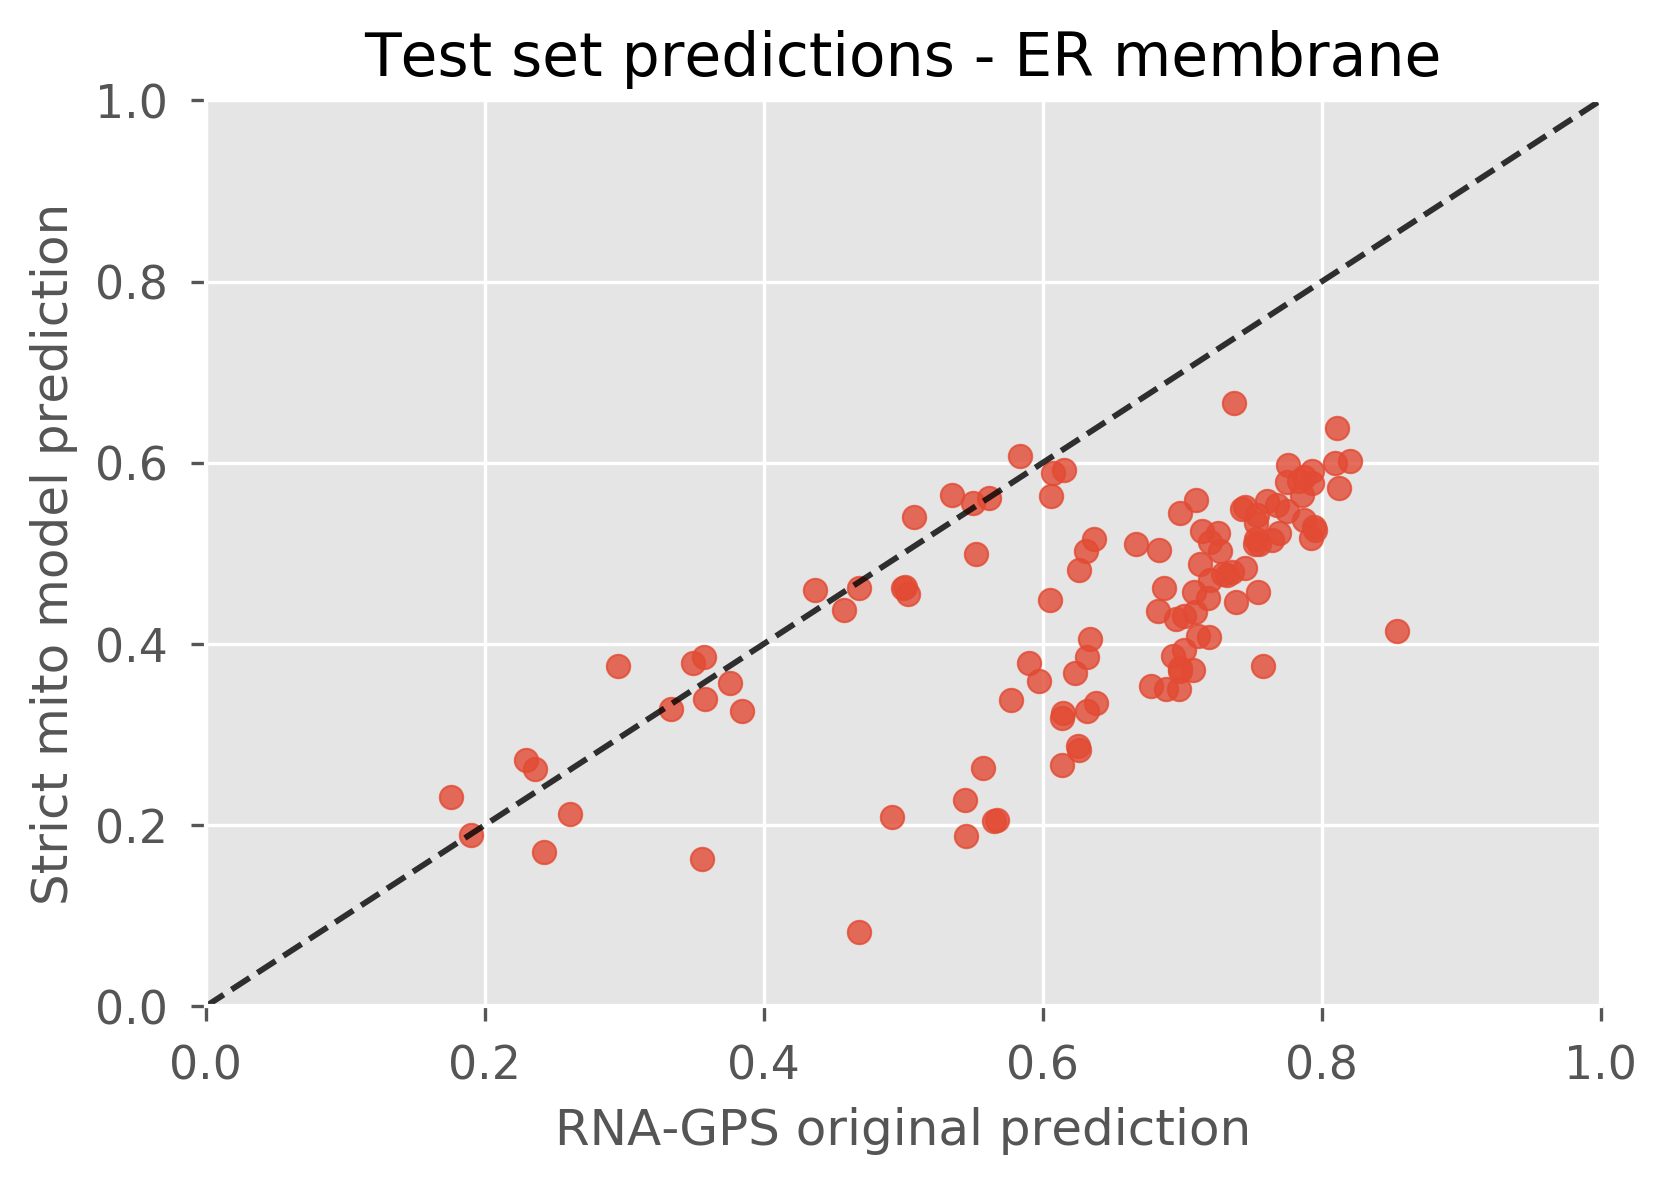

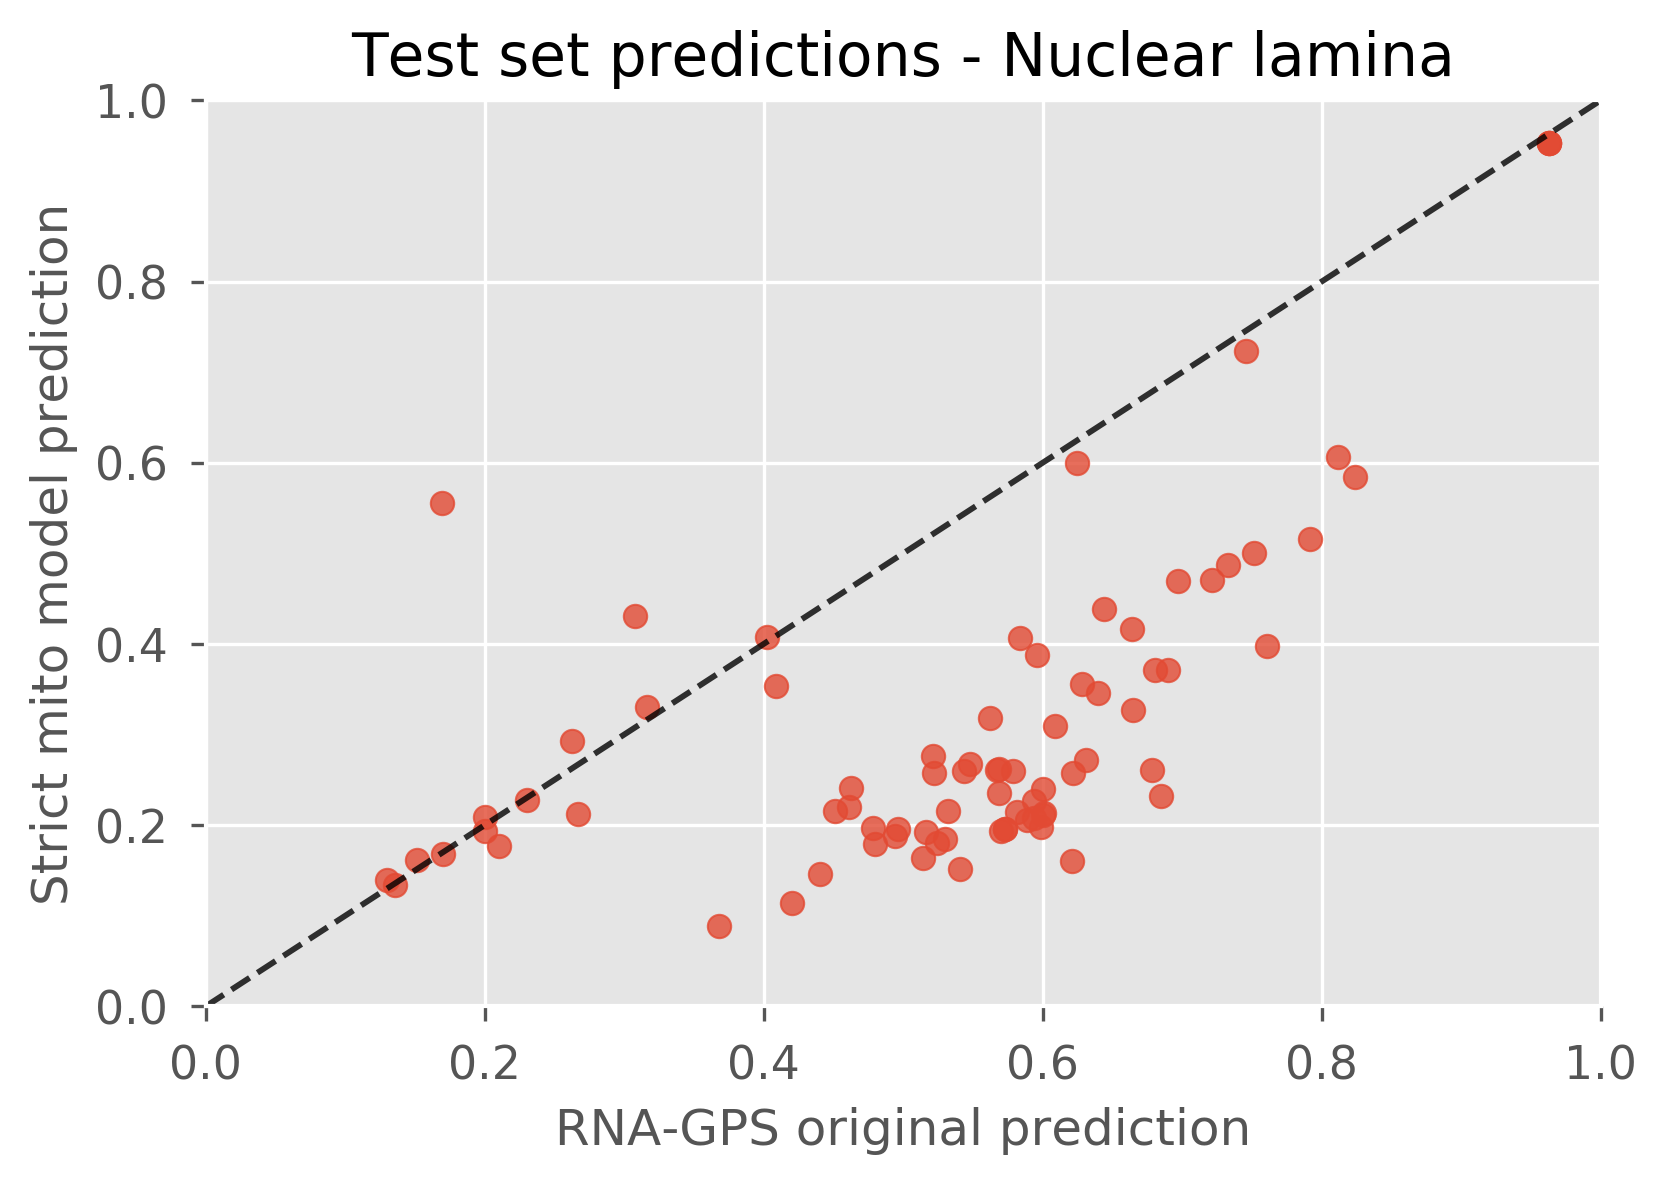

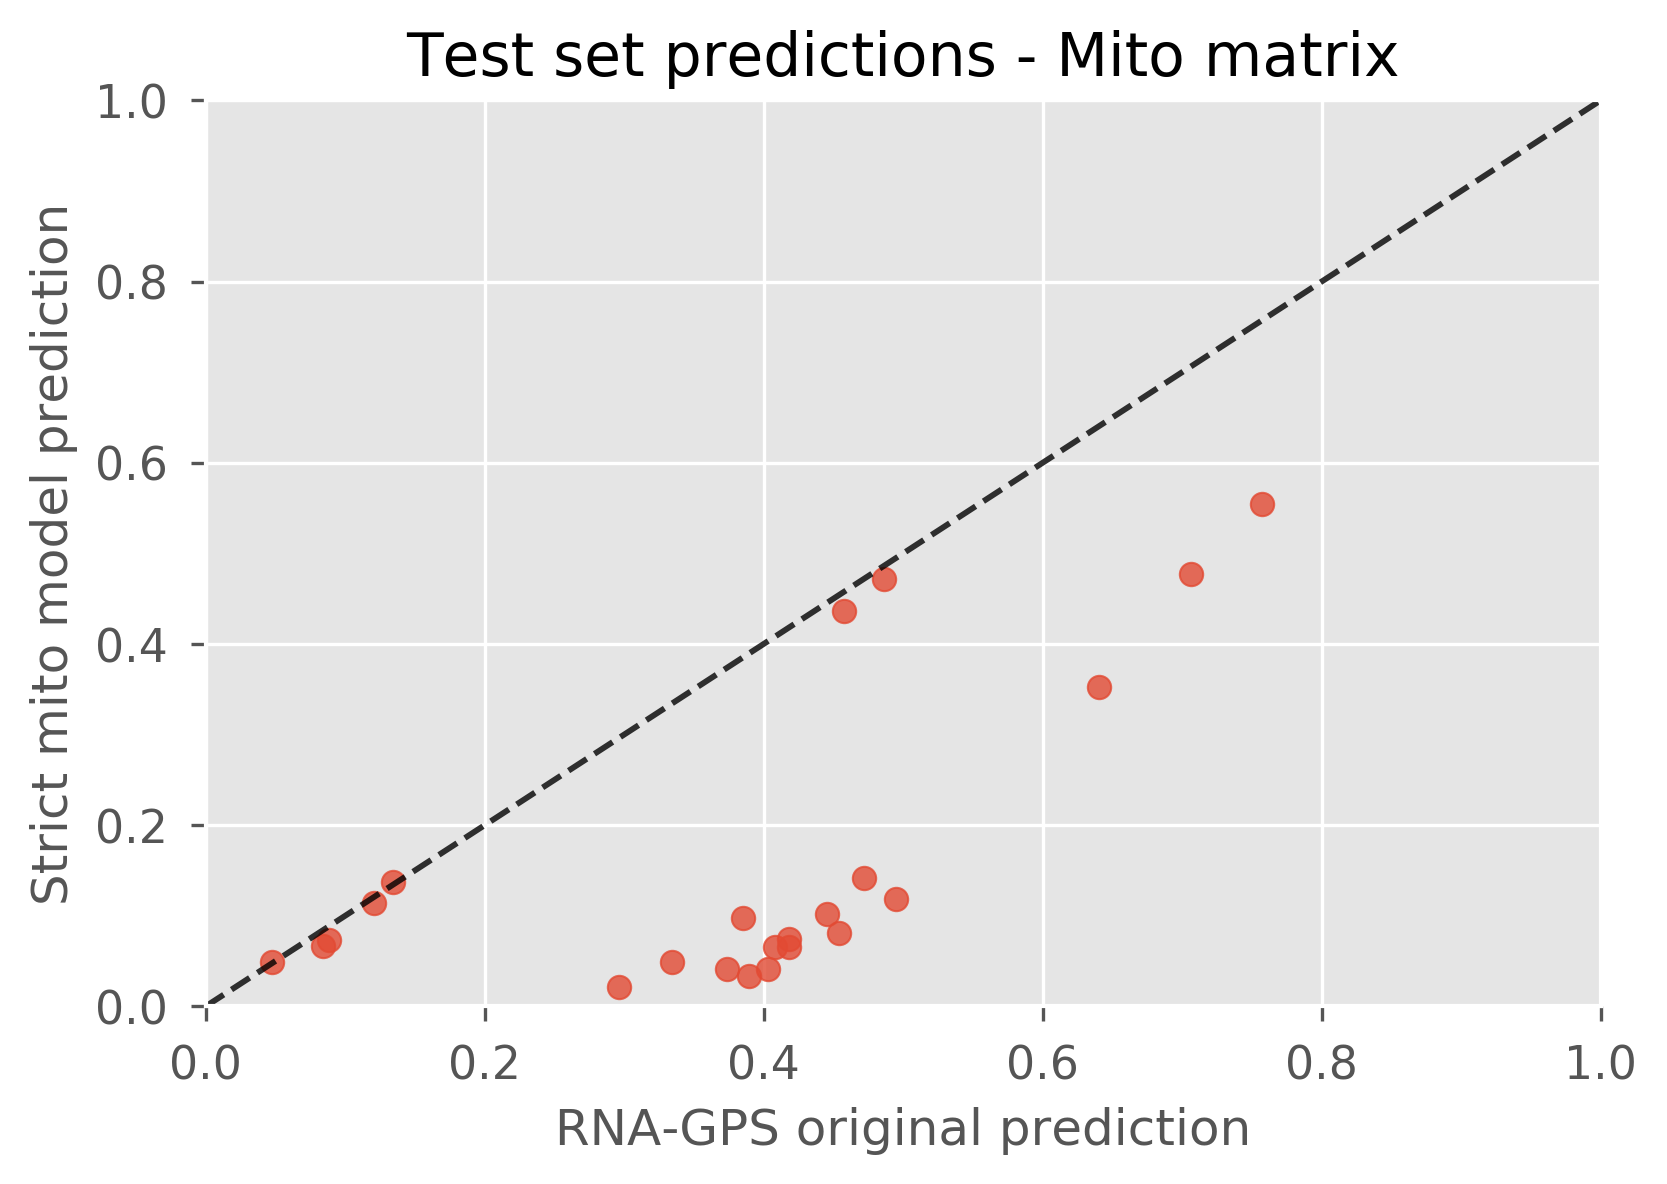

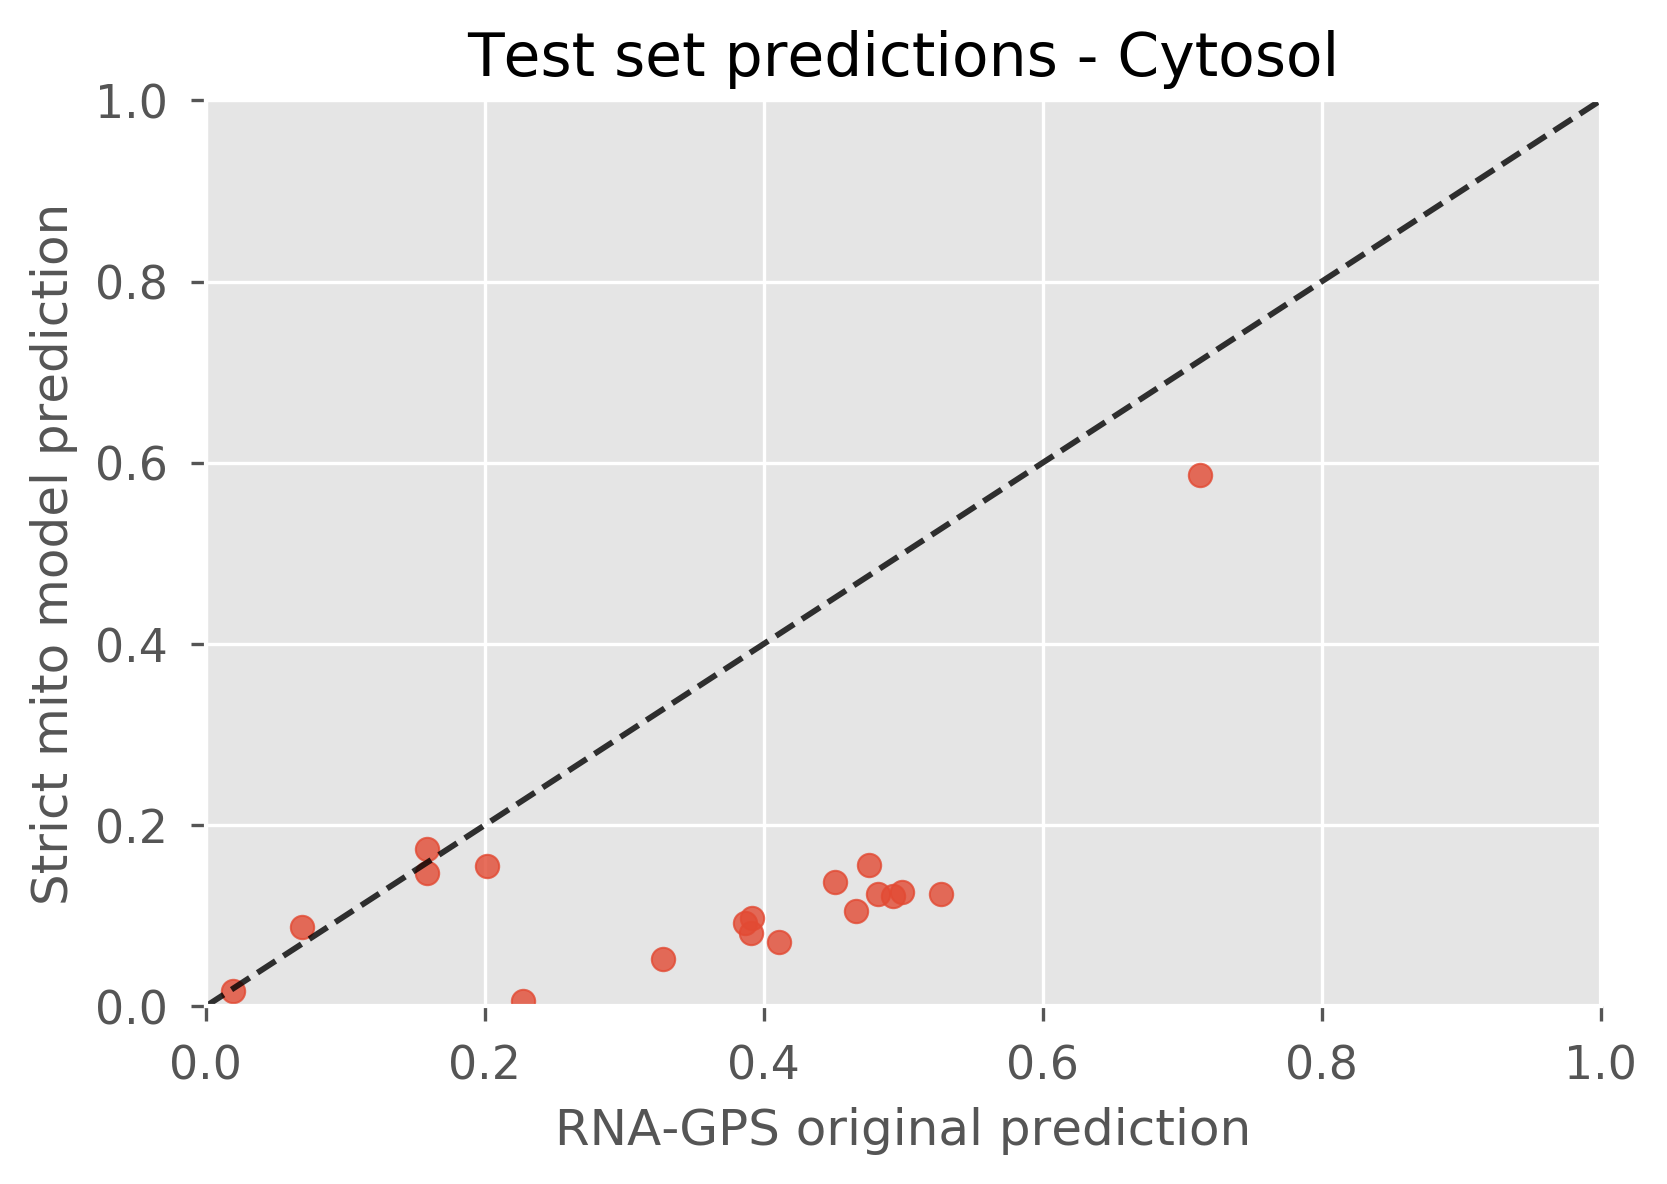

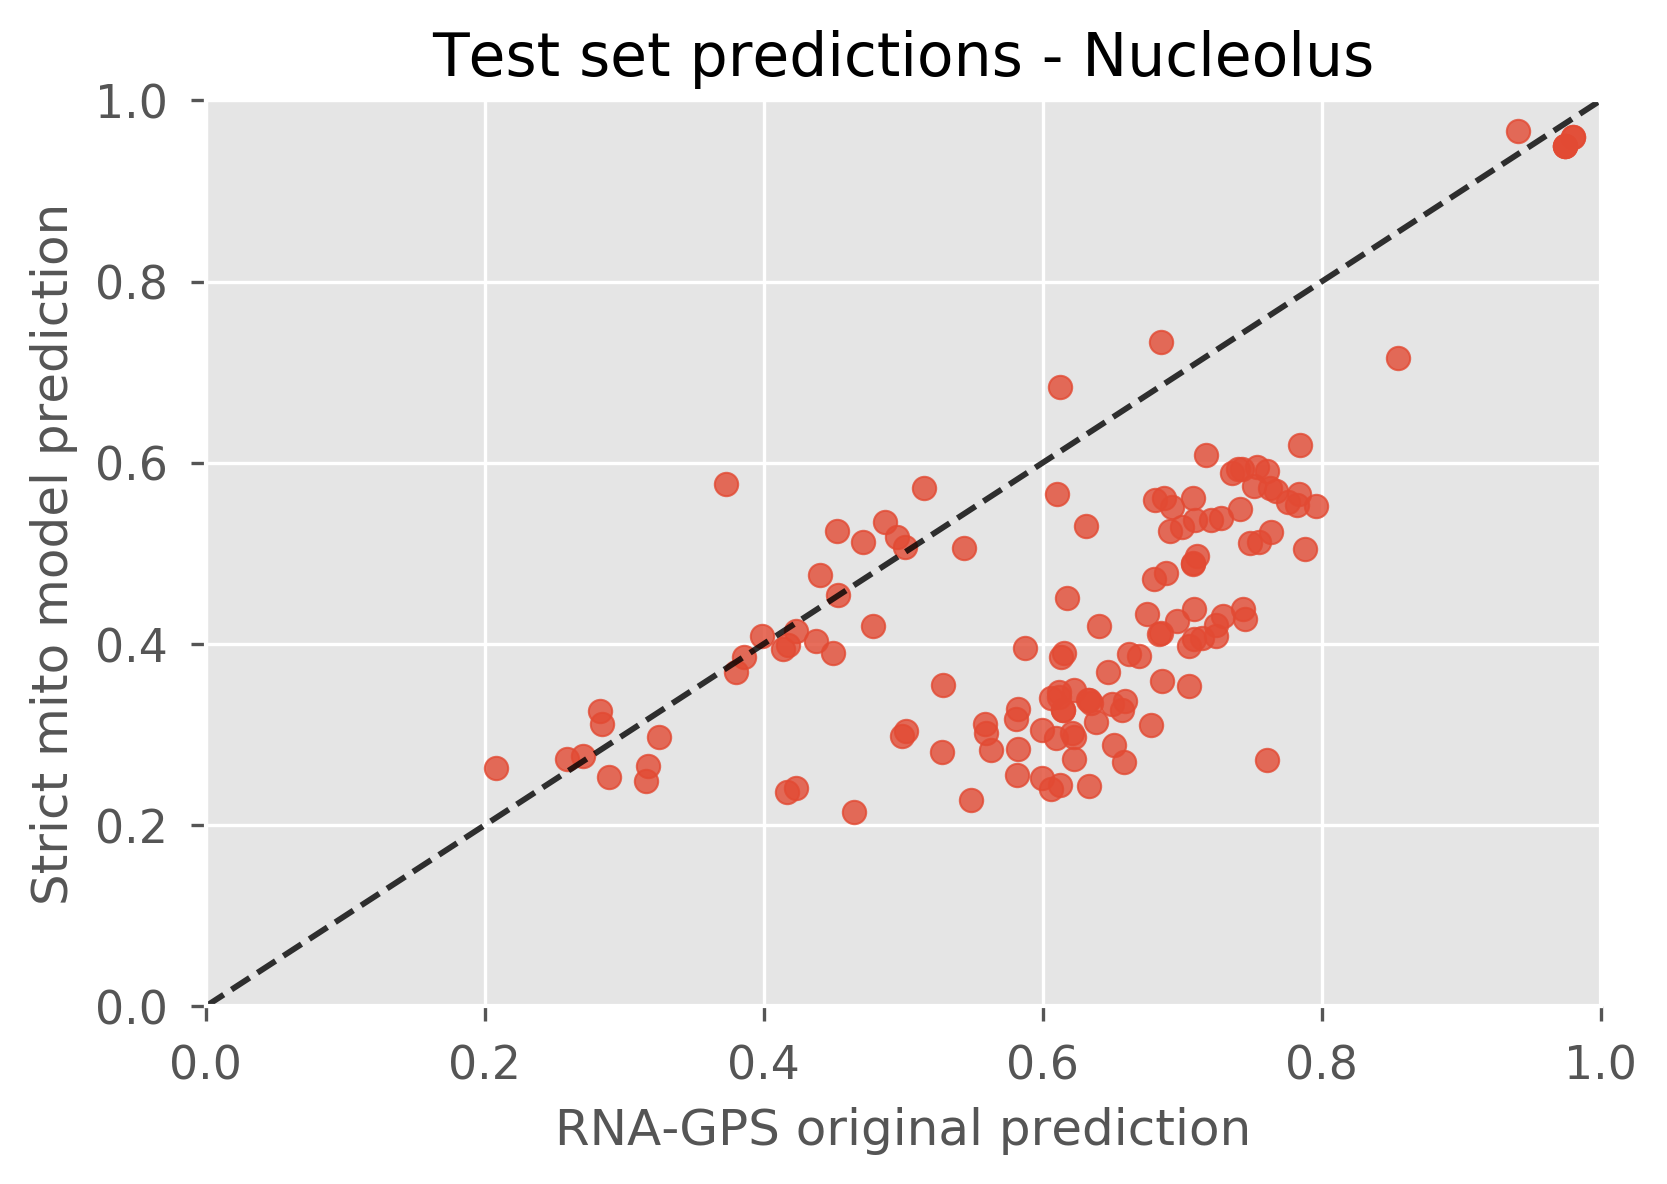

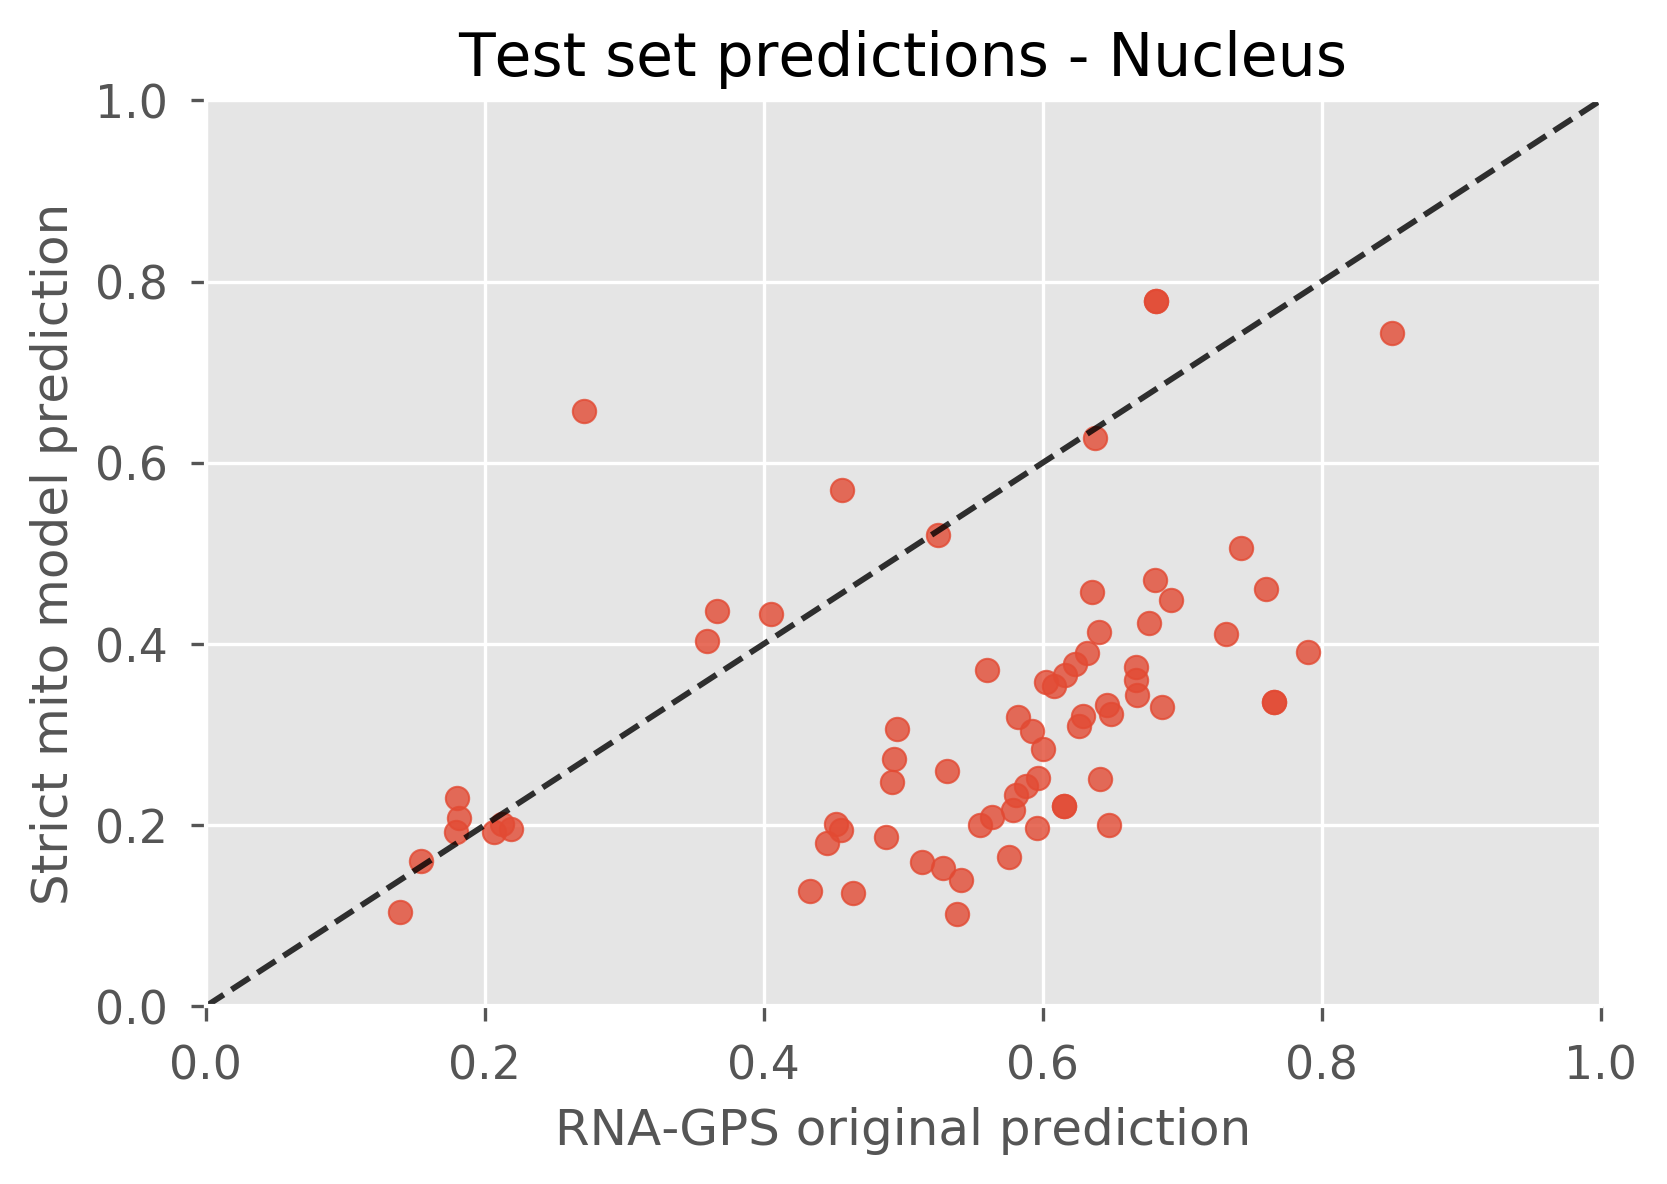

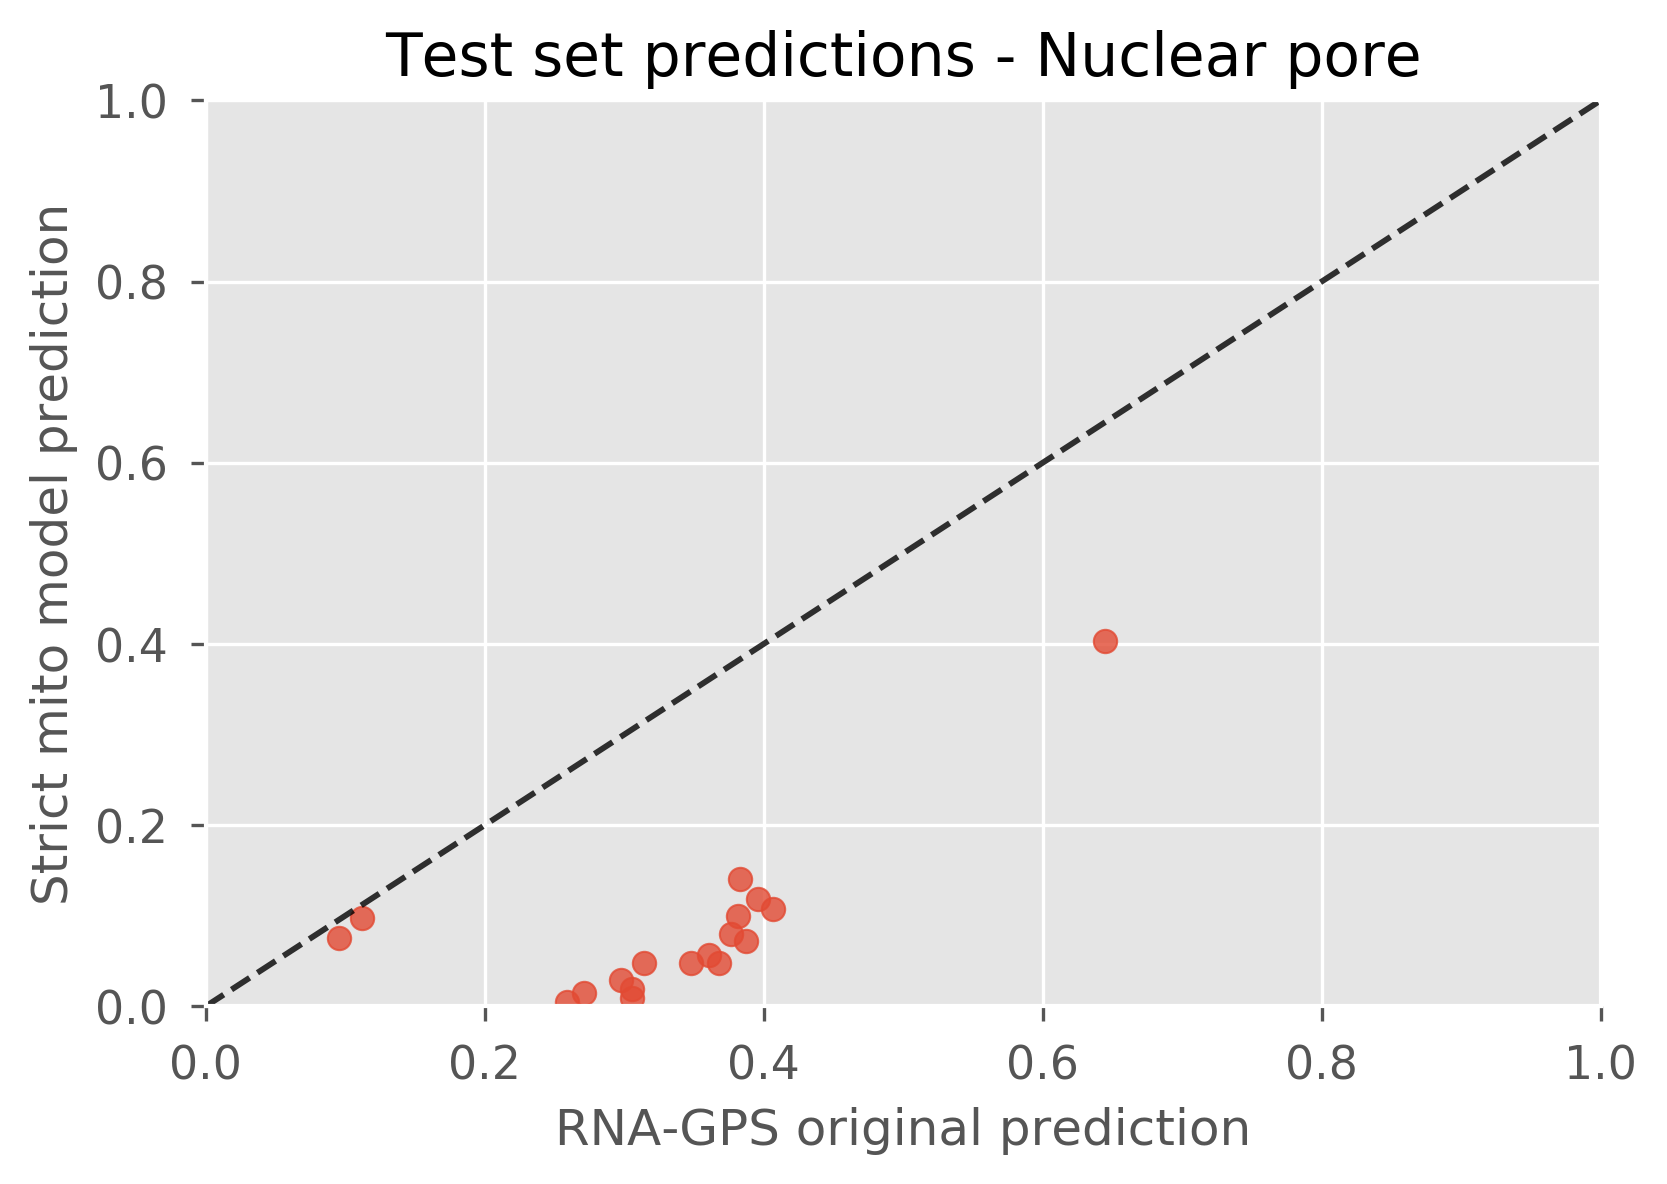

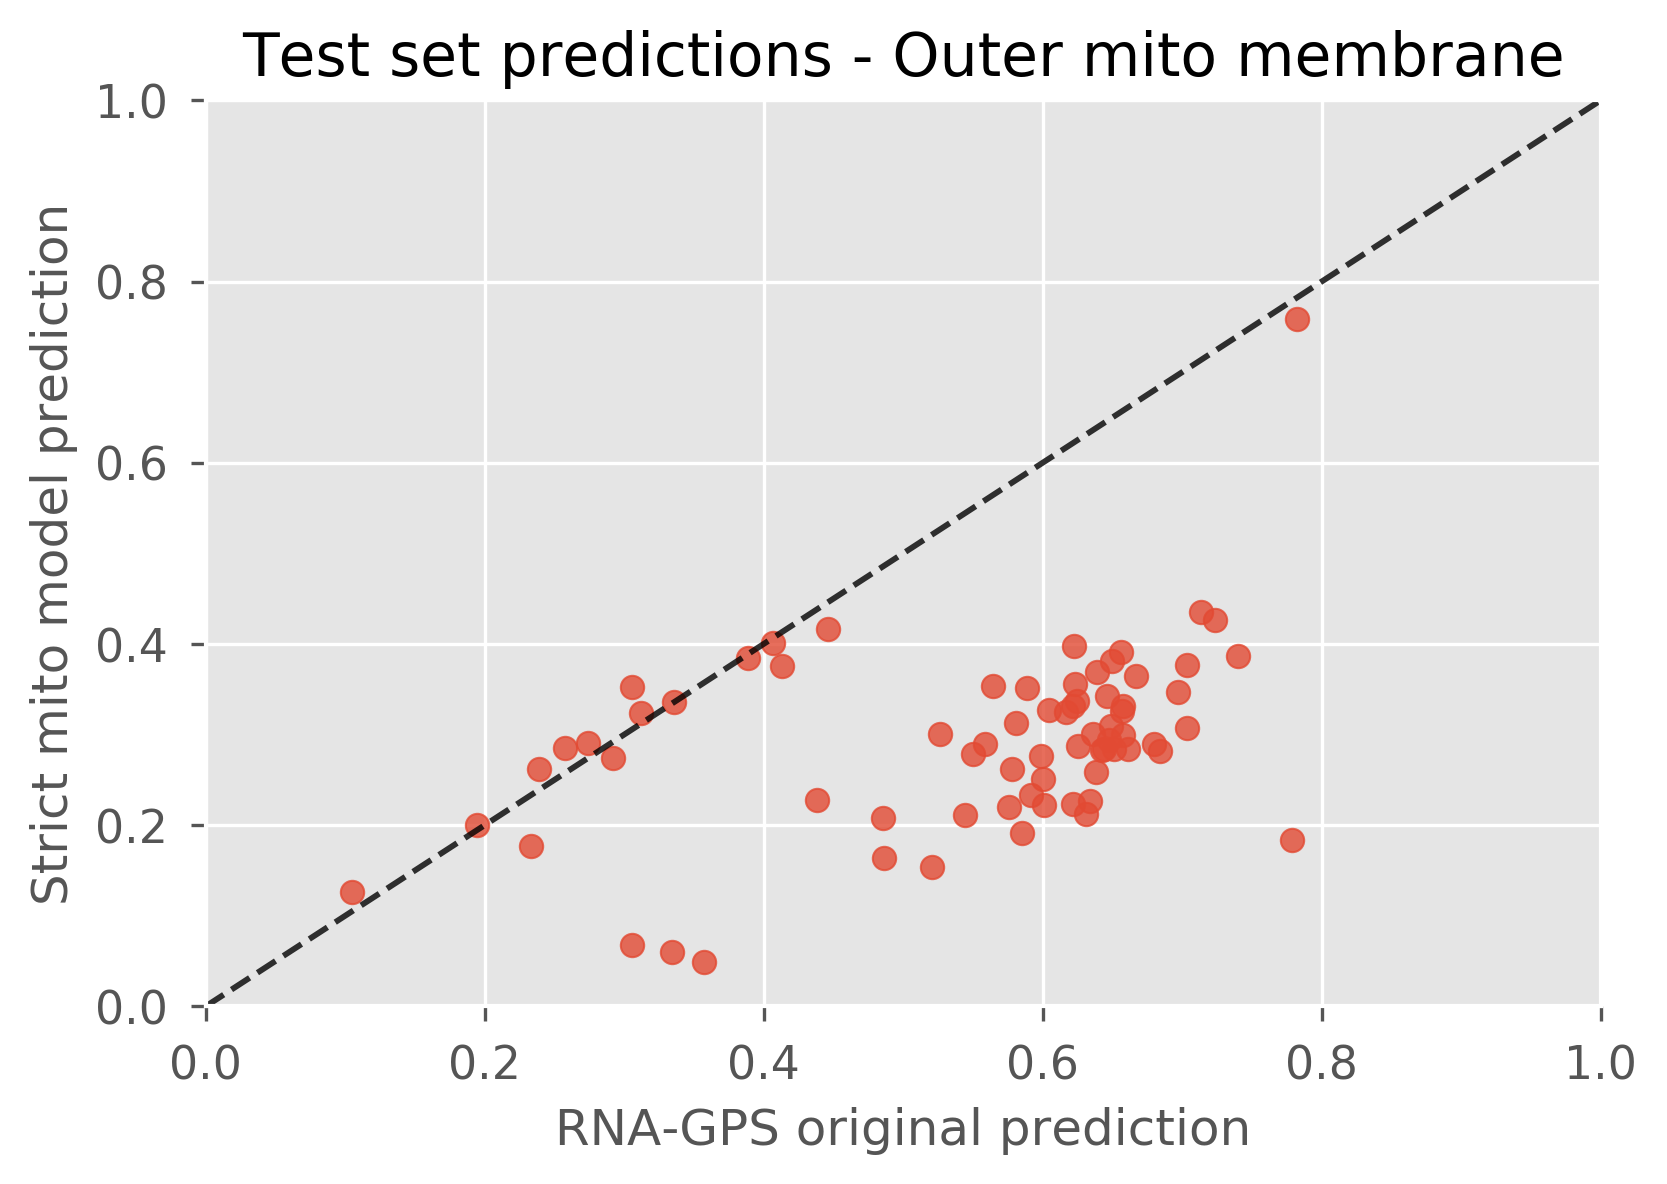

In [37]:
for i, localization in enumerate(data_loader.LOCALIZATION_FULL_NAME_DICT.values()):
    fig, ax = plt.subplots(dpi=300)
    ax.plot((0, 1), (0, 1), linestyle='--', color='black', alpha=0.8)
    ax.scatter(  # Select based on *original* labels
        test_probs_original[np.where(test_data[1][:, i]), i].flatten(),
        test_probs[np.where(test_data[1][:, i]), i].flatten(),
        alpha=0.8,
    )
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel='RNA-GPS original prediction',
        ylabel='Strict mito model prediction',
        title=f"Test set predictions - {localization}"
    )
    fig.show()

## Perform the same test, but for covid

In [38]:
def get_covid_mito_preds(model):
    """
    Return the mito matrix predictions from covid
    """
    identifiers = covid19.query_genbank()

    genome_seqs = []
    featurizations, predictions, names = [], [], []
    for identifier in tqdm.tqdm(identifiers):
        try:
            record = covid19.fetch_genbank(identifier)
            record_ft_dict = covid19.genbank_to_feature_dict(record)
            gene_names = covid19.get_feature_labels(record)
            assert len(gene_names) == len(record_ft_dict["CDS"])
            assert record_ft_dict["CDS"]

            five_utr = record_ft_dict["5'UTR"]
            assert len(five_utr) == 1
            three_utr = record_ft_dict["3'UTR"]
            assert len(three_utr) == 1
            genome = str(record.seq)
            five_utr_seq = covid19.seq_feature_to_sequence(five_utr[0], genome)
            three_utr_seq = covid19.seq_feature_to_sequence(three_utr[0], genome)
            cds_seq = genome[five_utr[0].location.end : three_utr[0].location.start]

            ft = covid19.featurize(
                [five_utr_seq, cds_seq, three_utr_seq], [False, False, False]
            )
            preds = model_utils.list_preds_to_array_preds(model.predict_proba(ft)).squeeze()
            names.append(record.name)
            featurizations.append(ft)
            predictions.append(preds)
            genome_seqs.append(five_utr_seq + cds_seq + three_utr_seq)

        except (AssertionError) as _err:
            continue

    featurizations = pd.DataFrame(data=np.vstack(featurizations), index=names)
    predictions = pd.DataFrame(
        data=np.vstack(predictions),
        index=names,
        columns=data_loader.LOCALIZATION_FULL_NAME_DICT.values(),
    )

    return predictions

In [39]:
strict_mito_covid_preds = get_covid_mito_preds(rf_model)

INFO:root:Loaded genk query disk cache: /storage/wukevin/projects/rnagps/covid19/genbank_query_cache.json
INFO:root:Query found in disk cache, returning cached results
100%|██████████| 539/539 [01:10<00:00,  4.24it/s]


In [40]:
rnagps_covid_preds = get_covid_mito_preds(RNAGPS)

100%|██████████| 539/539 [01:08<00:00,  4.27it/s]


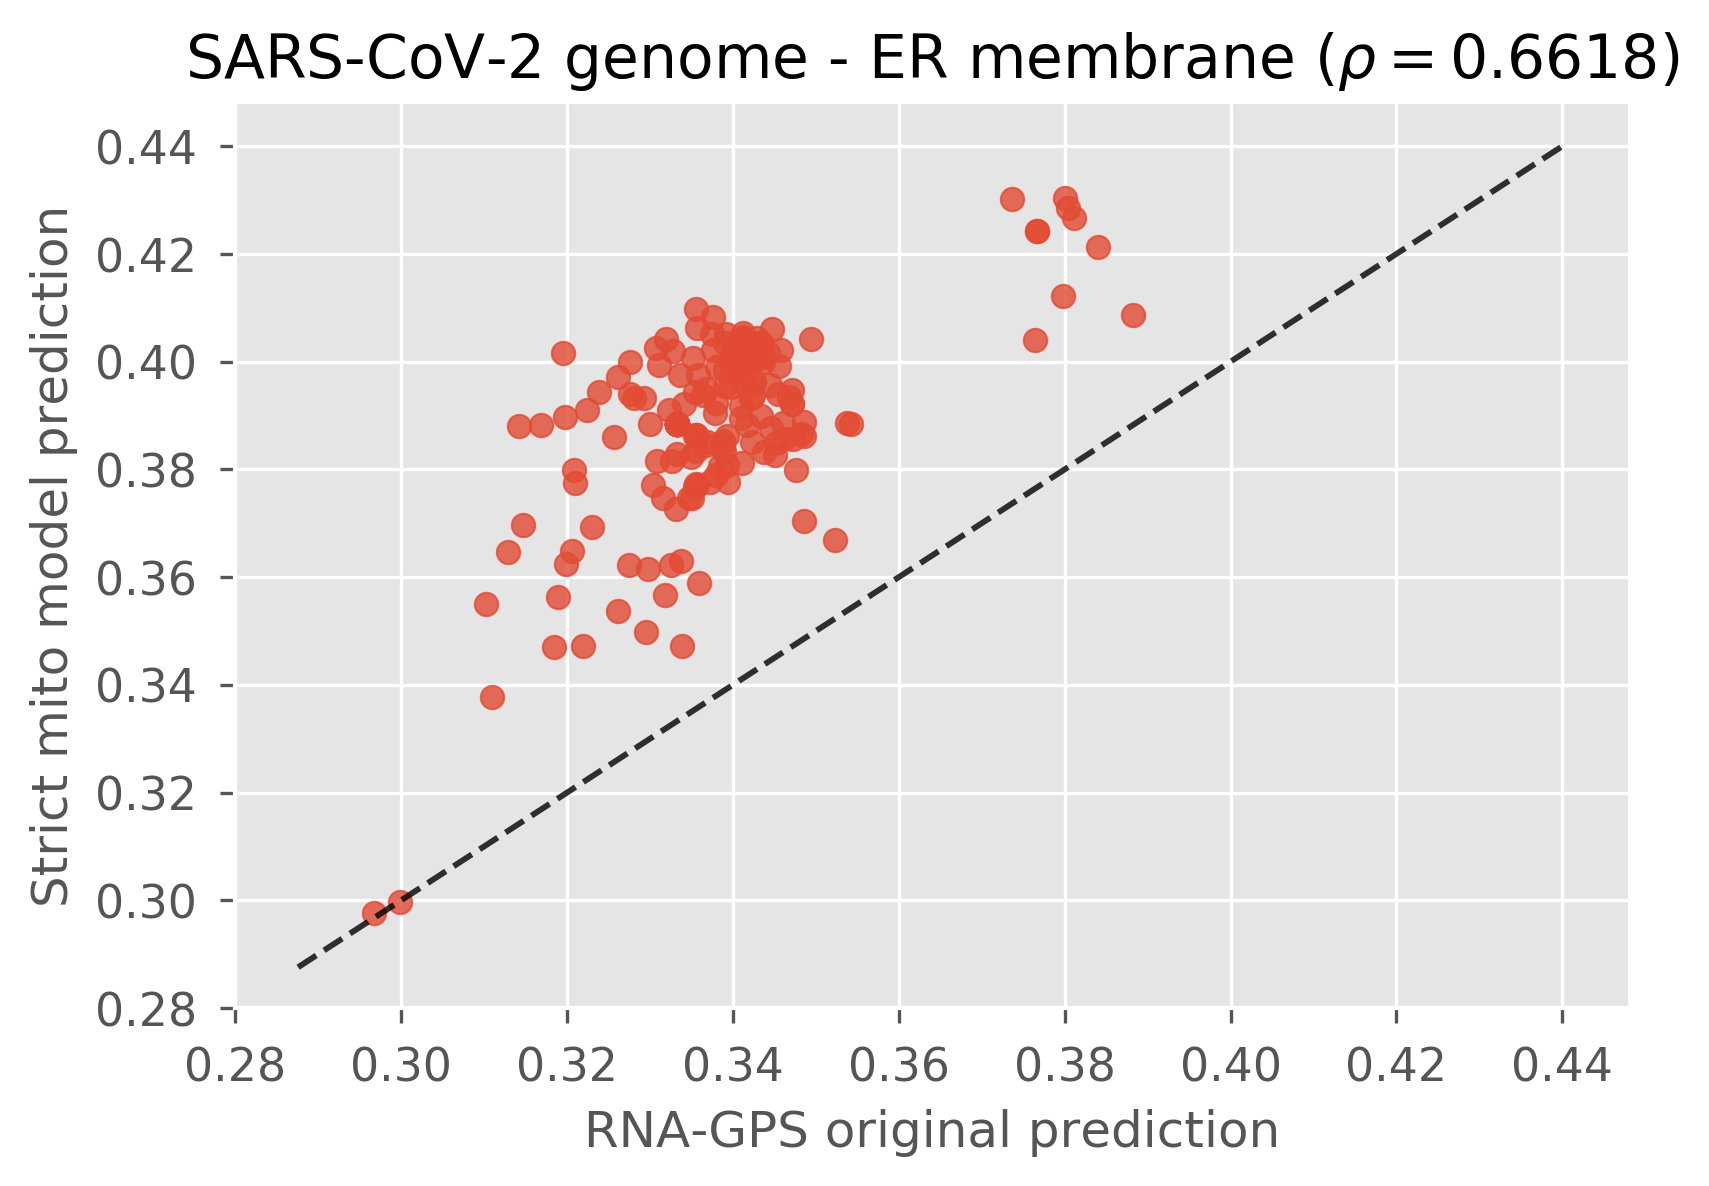

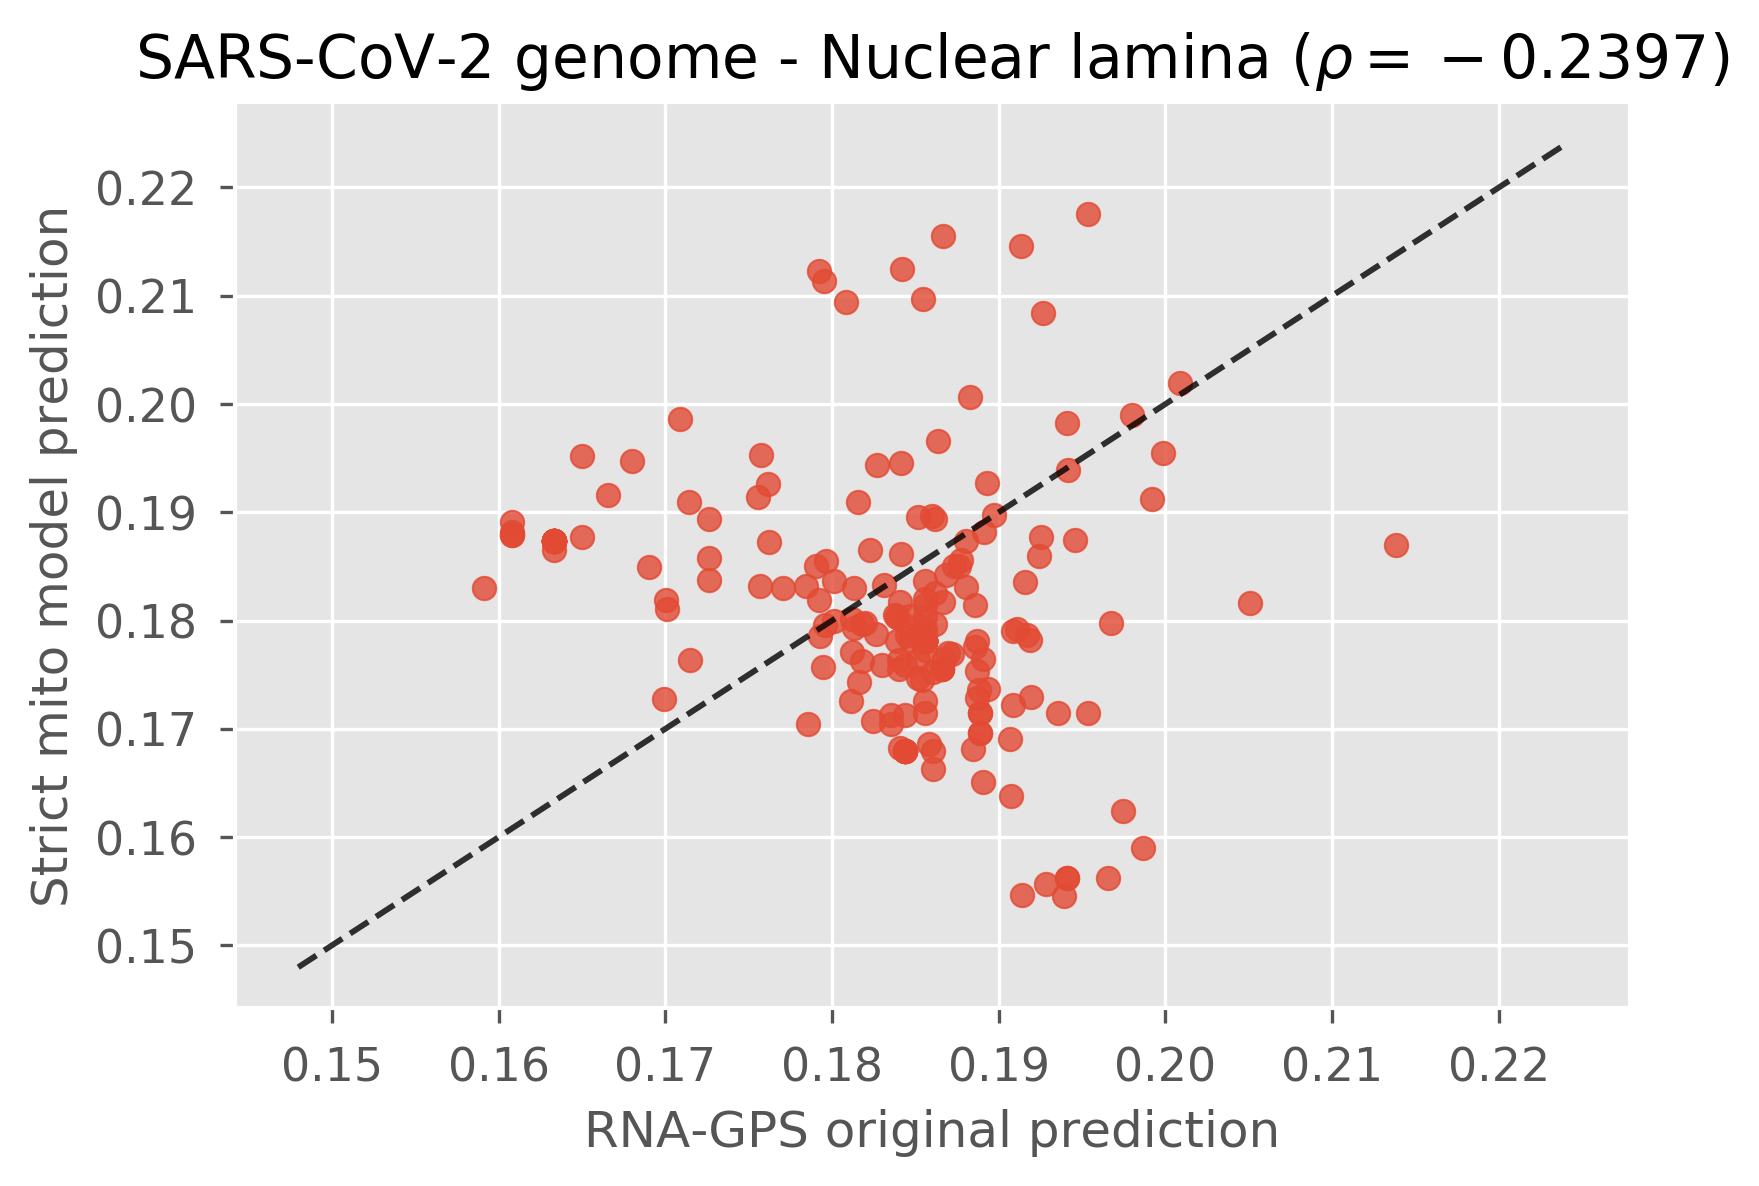

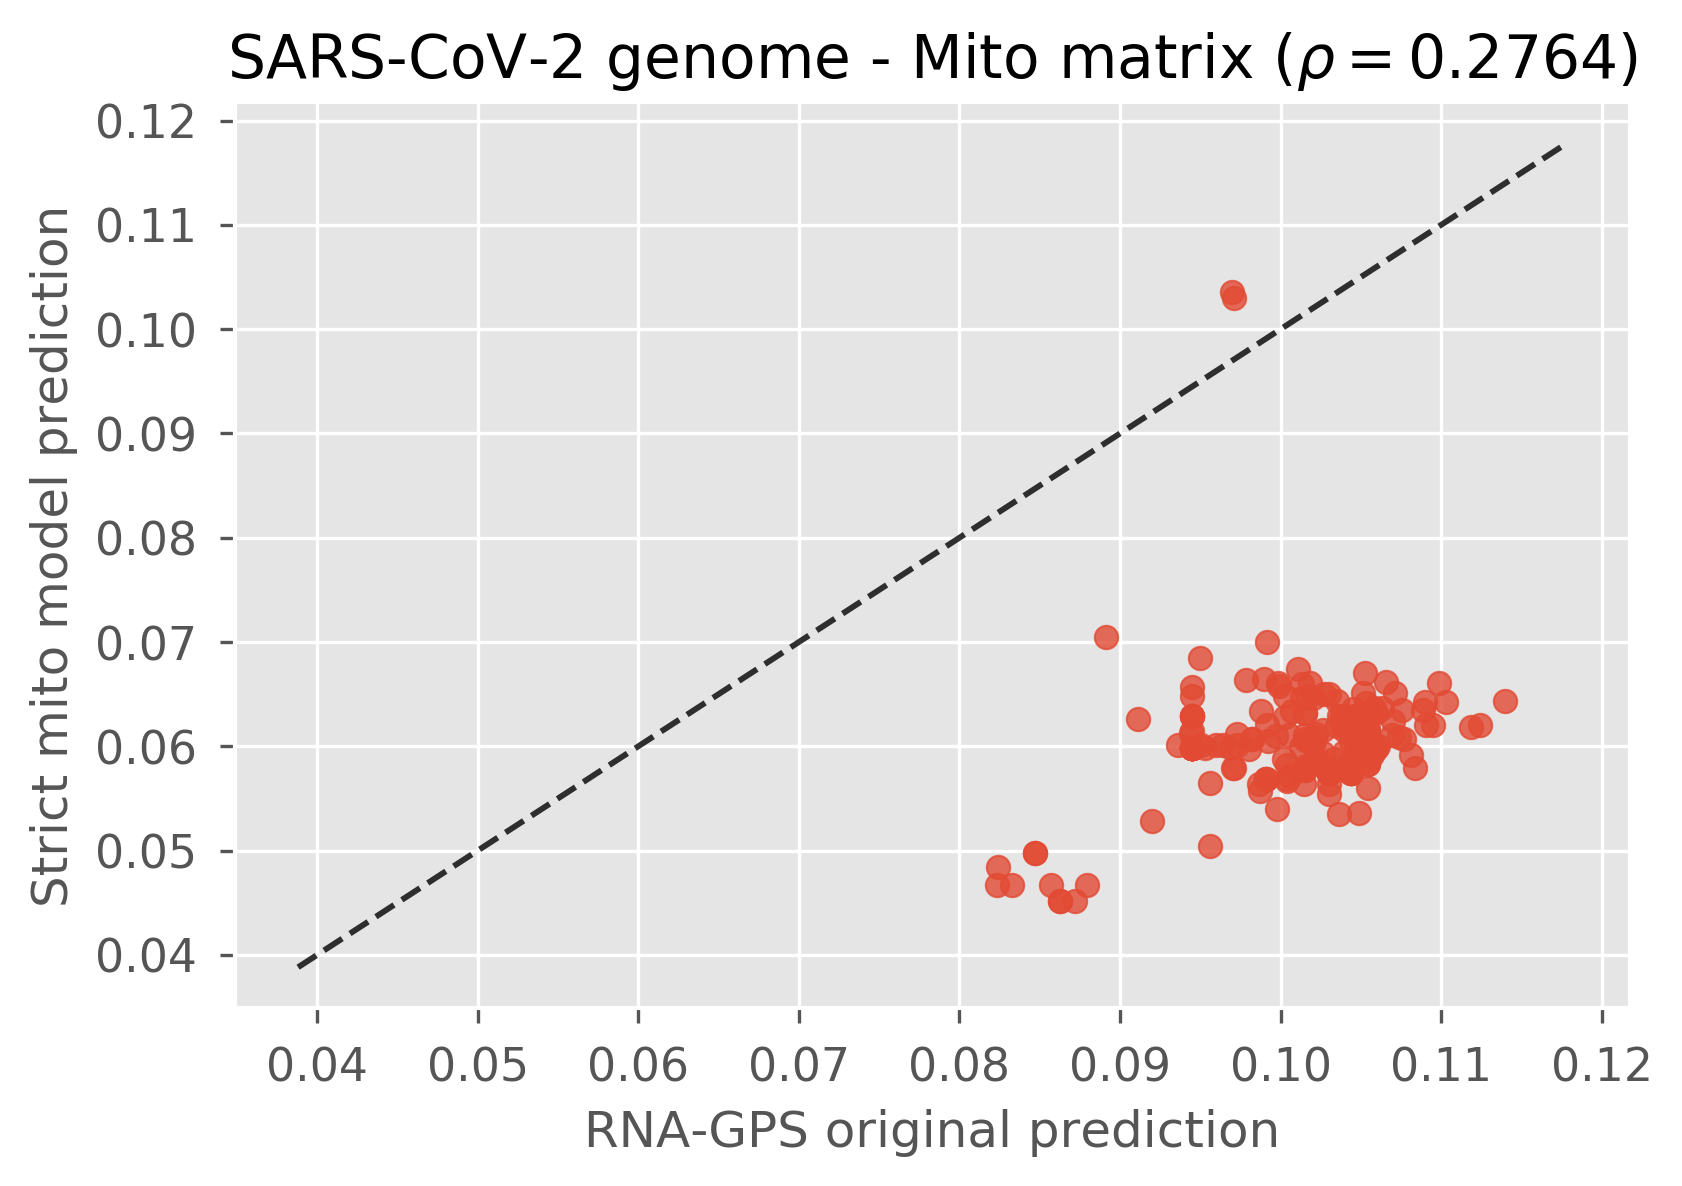

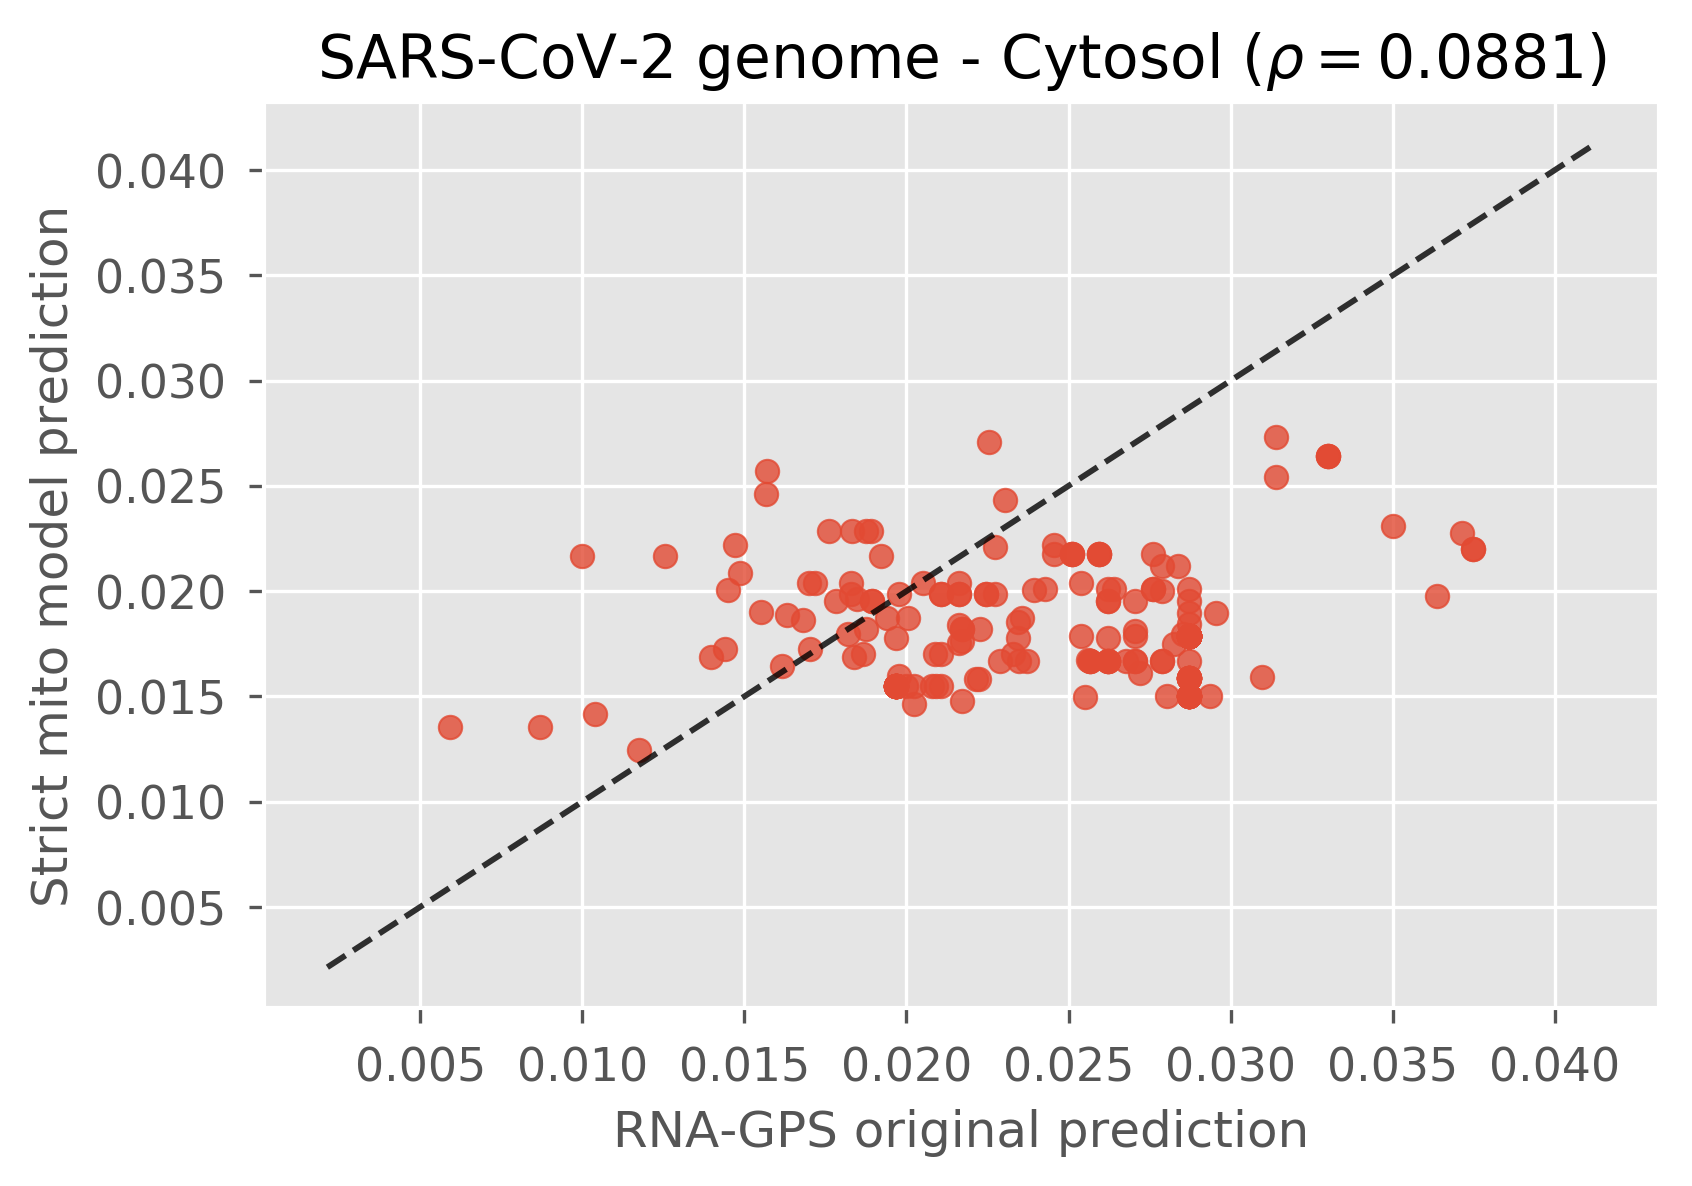

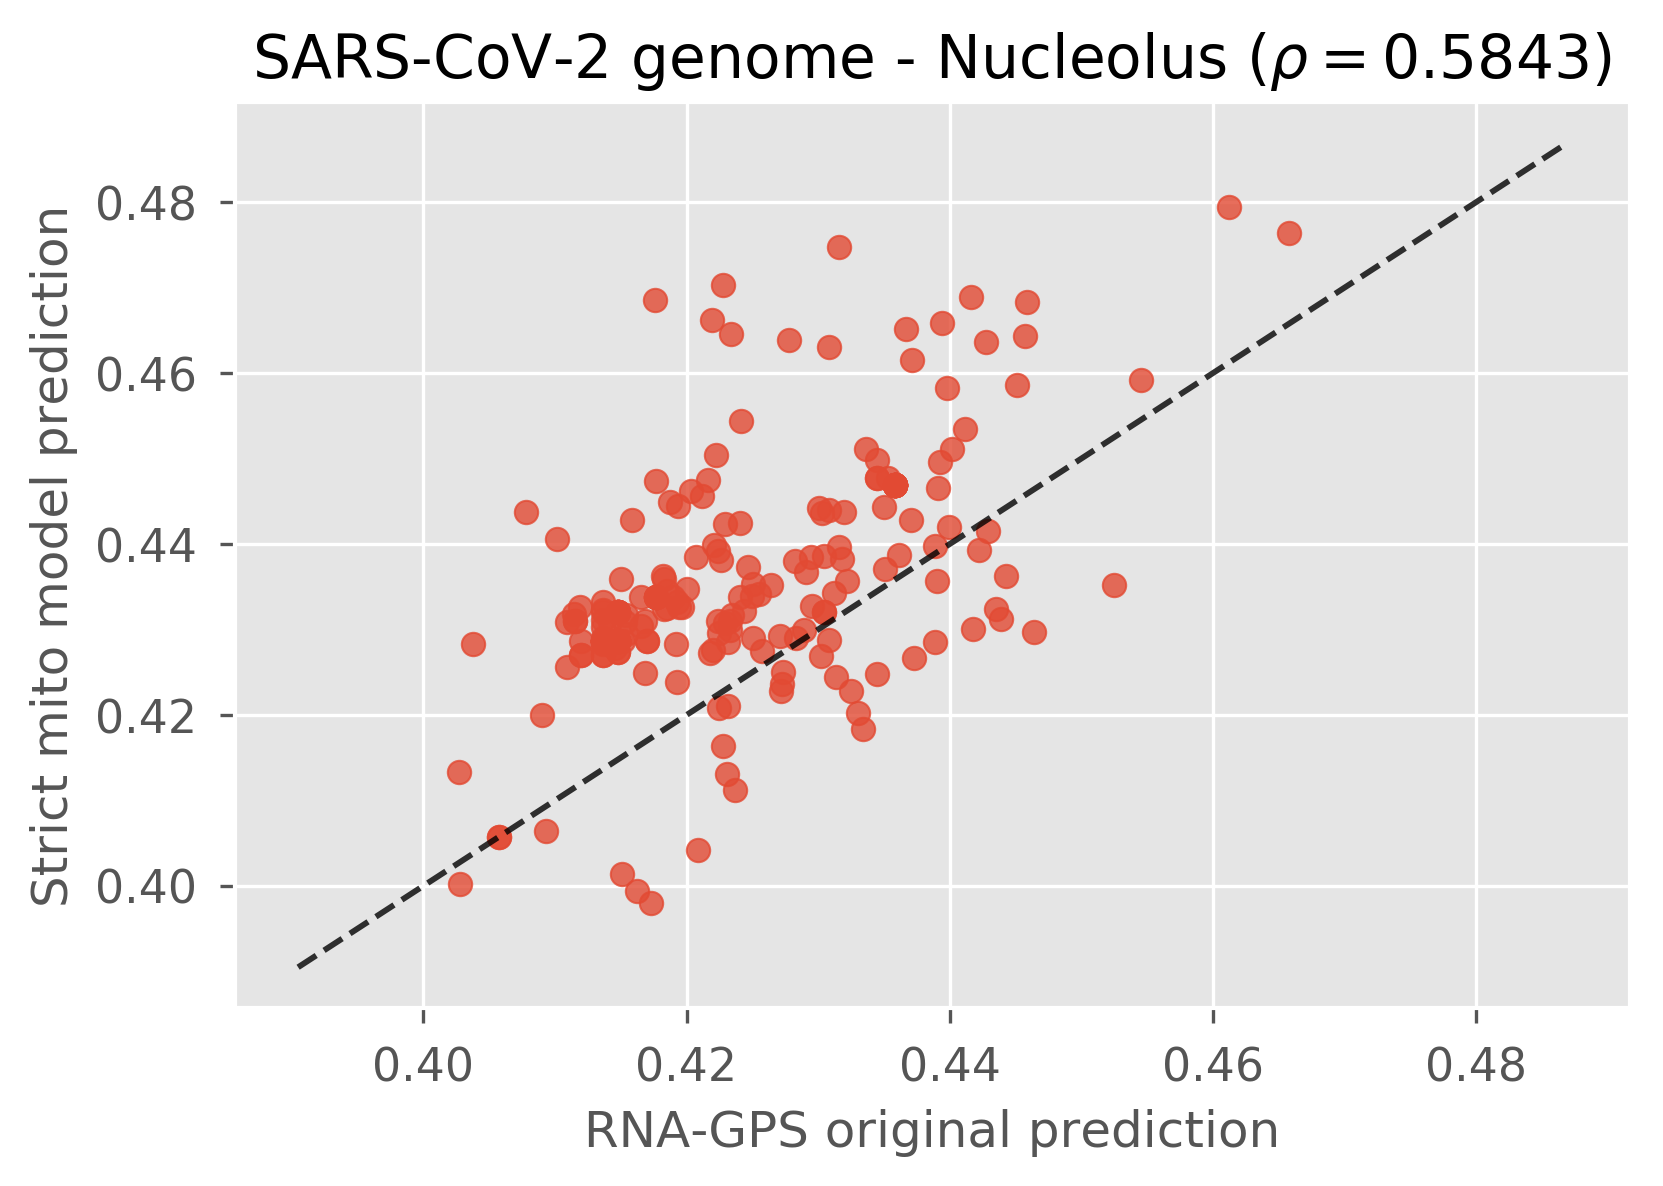

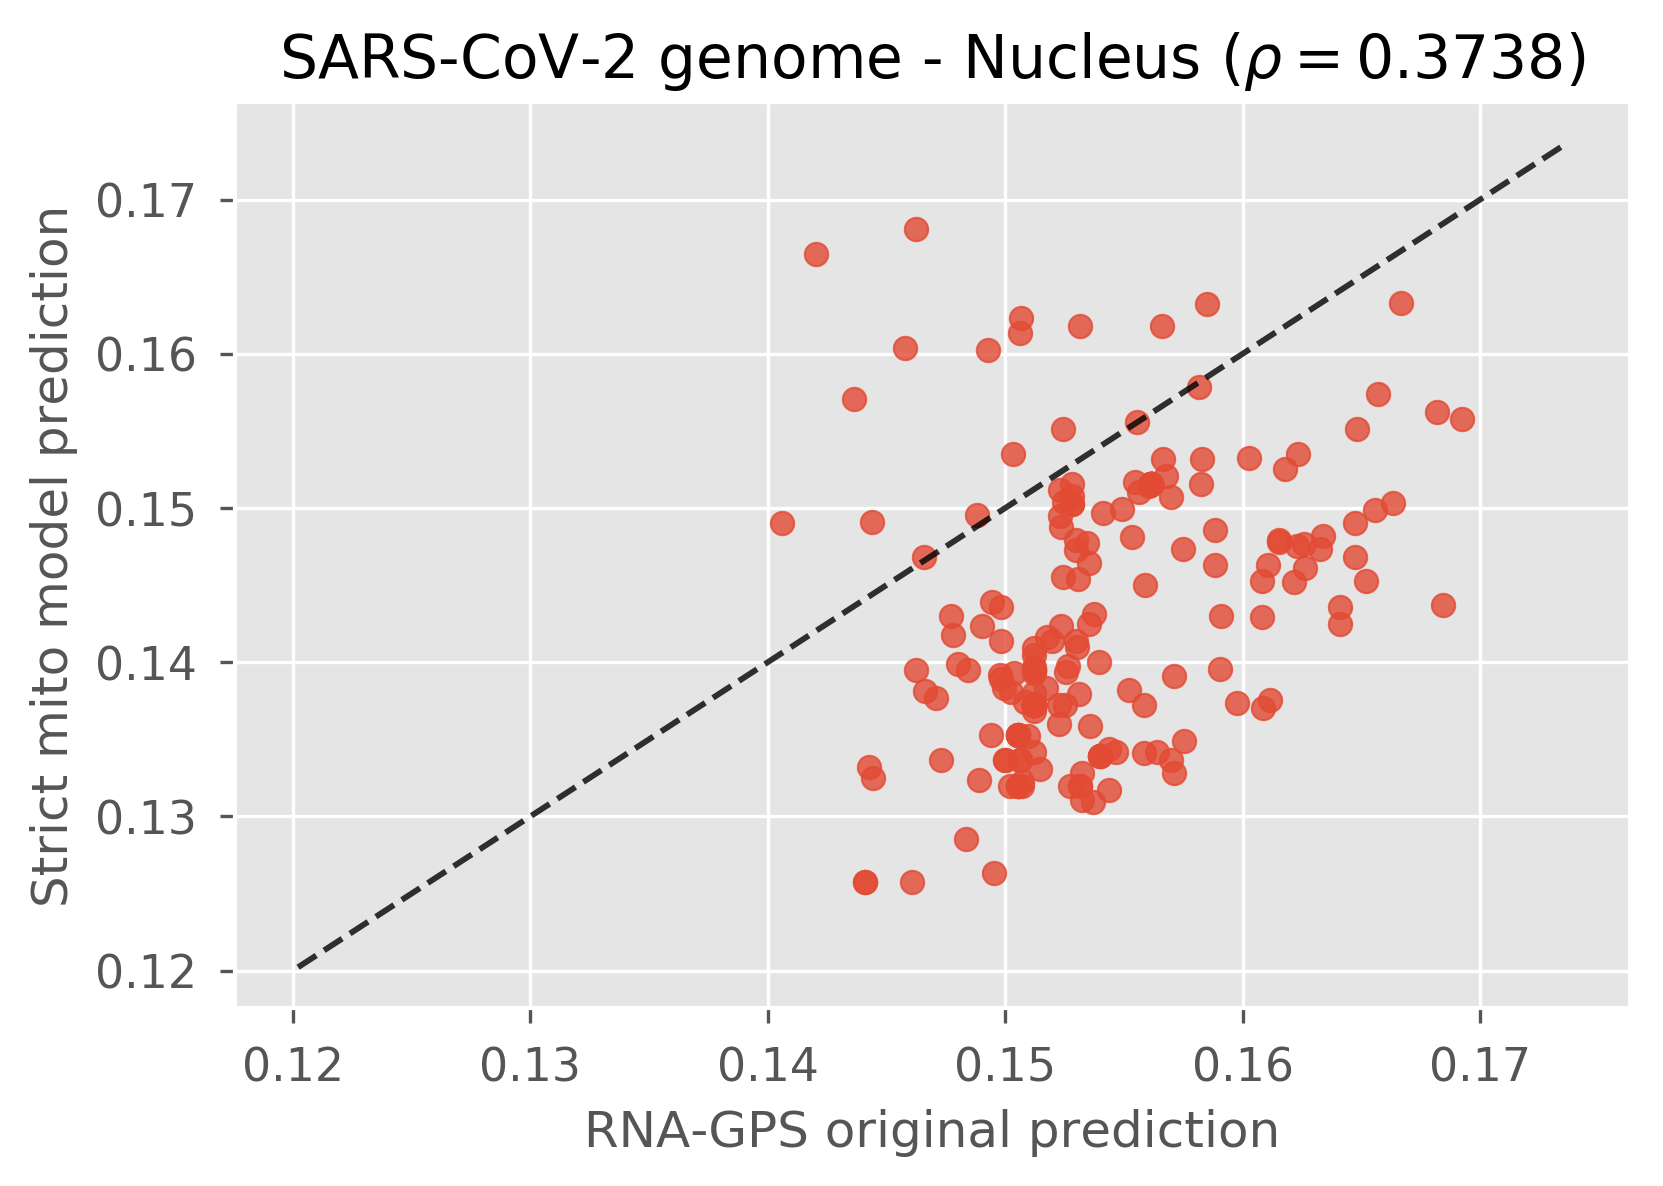

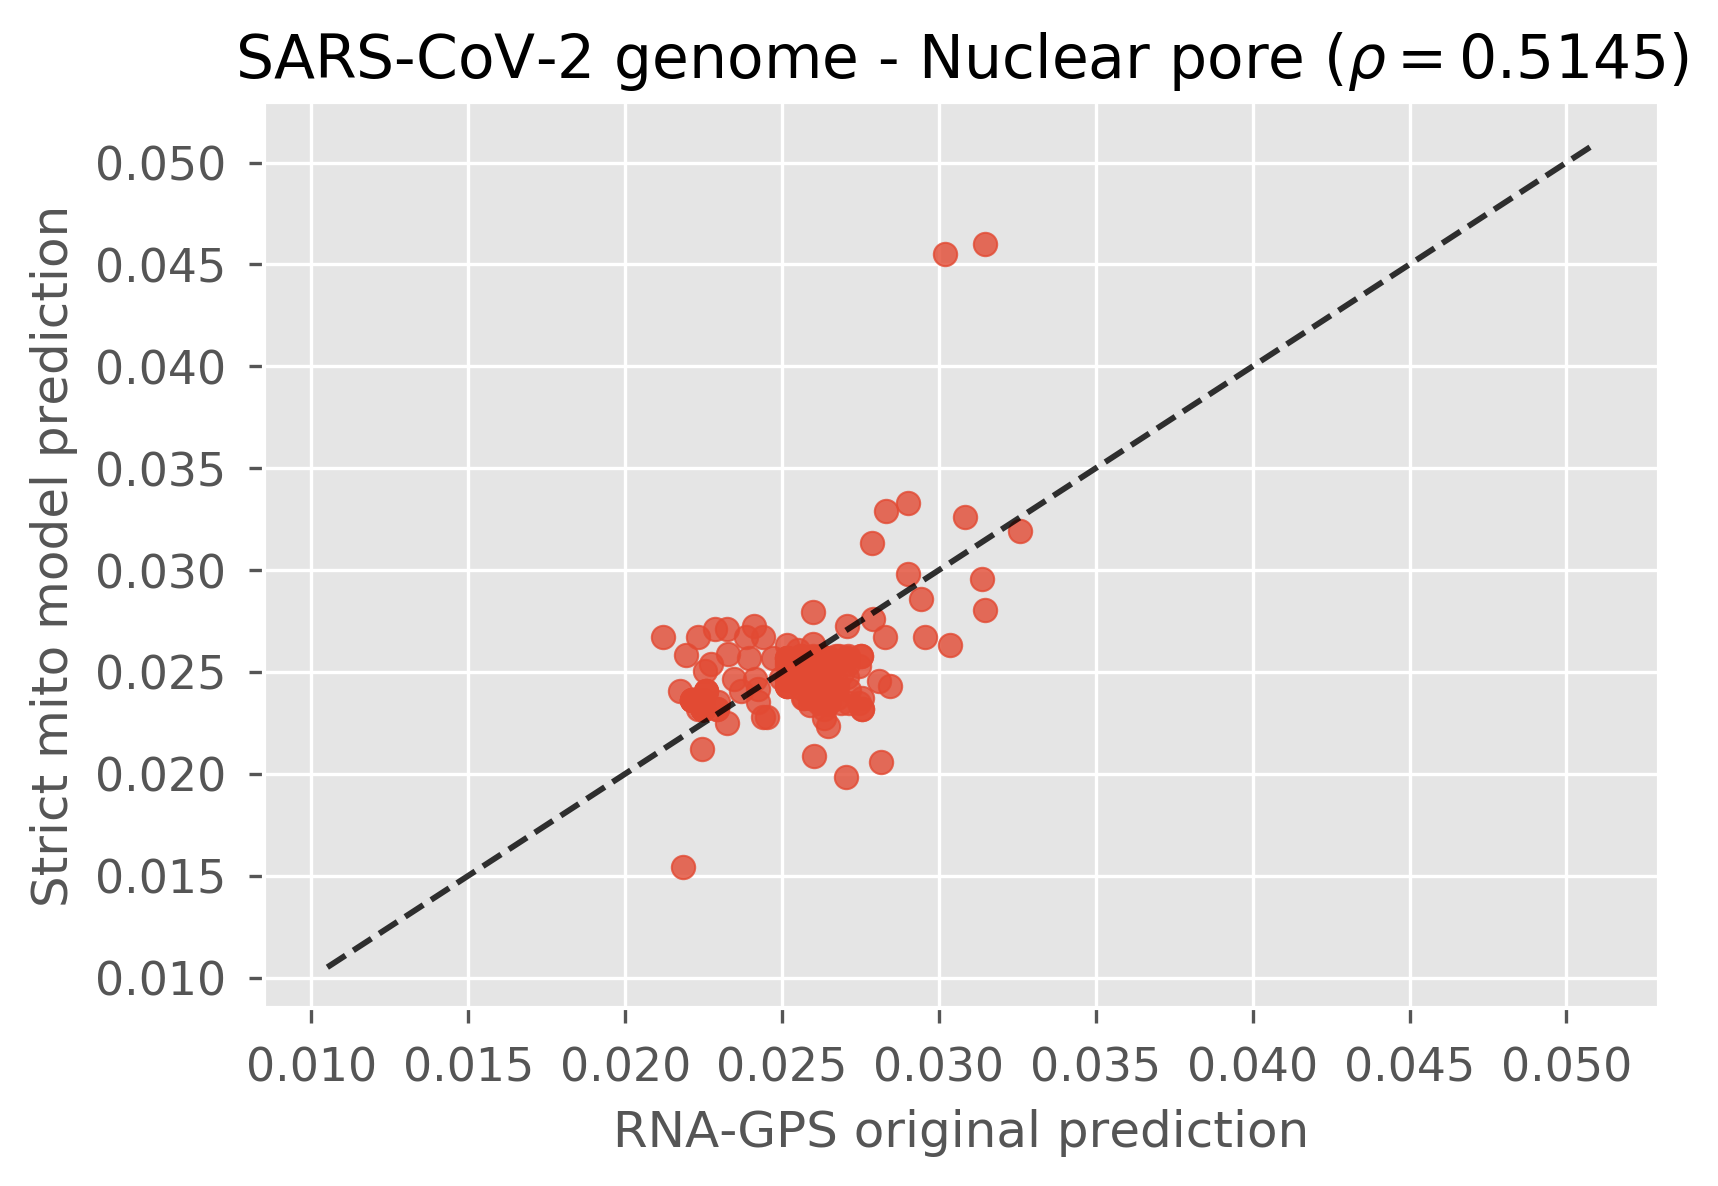

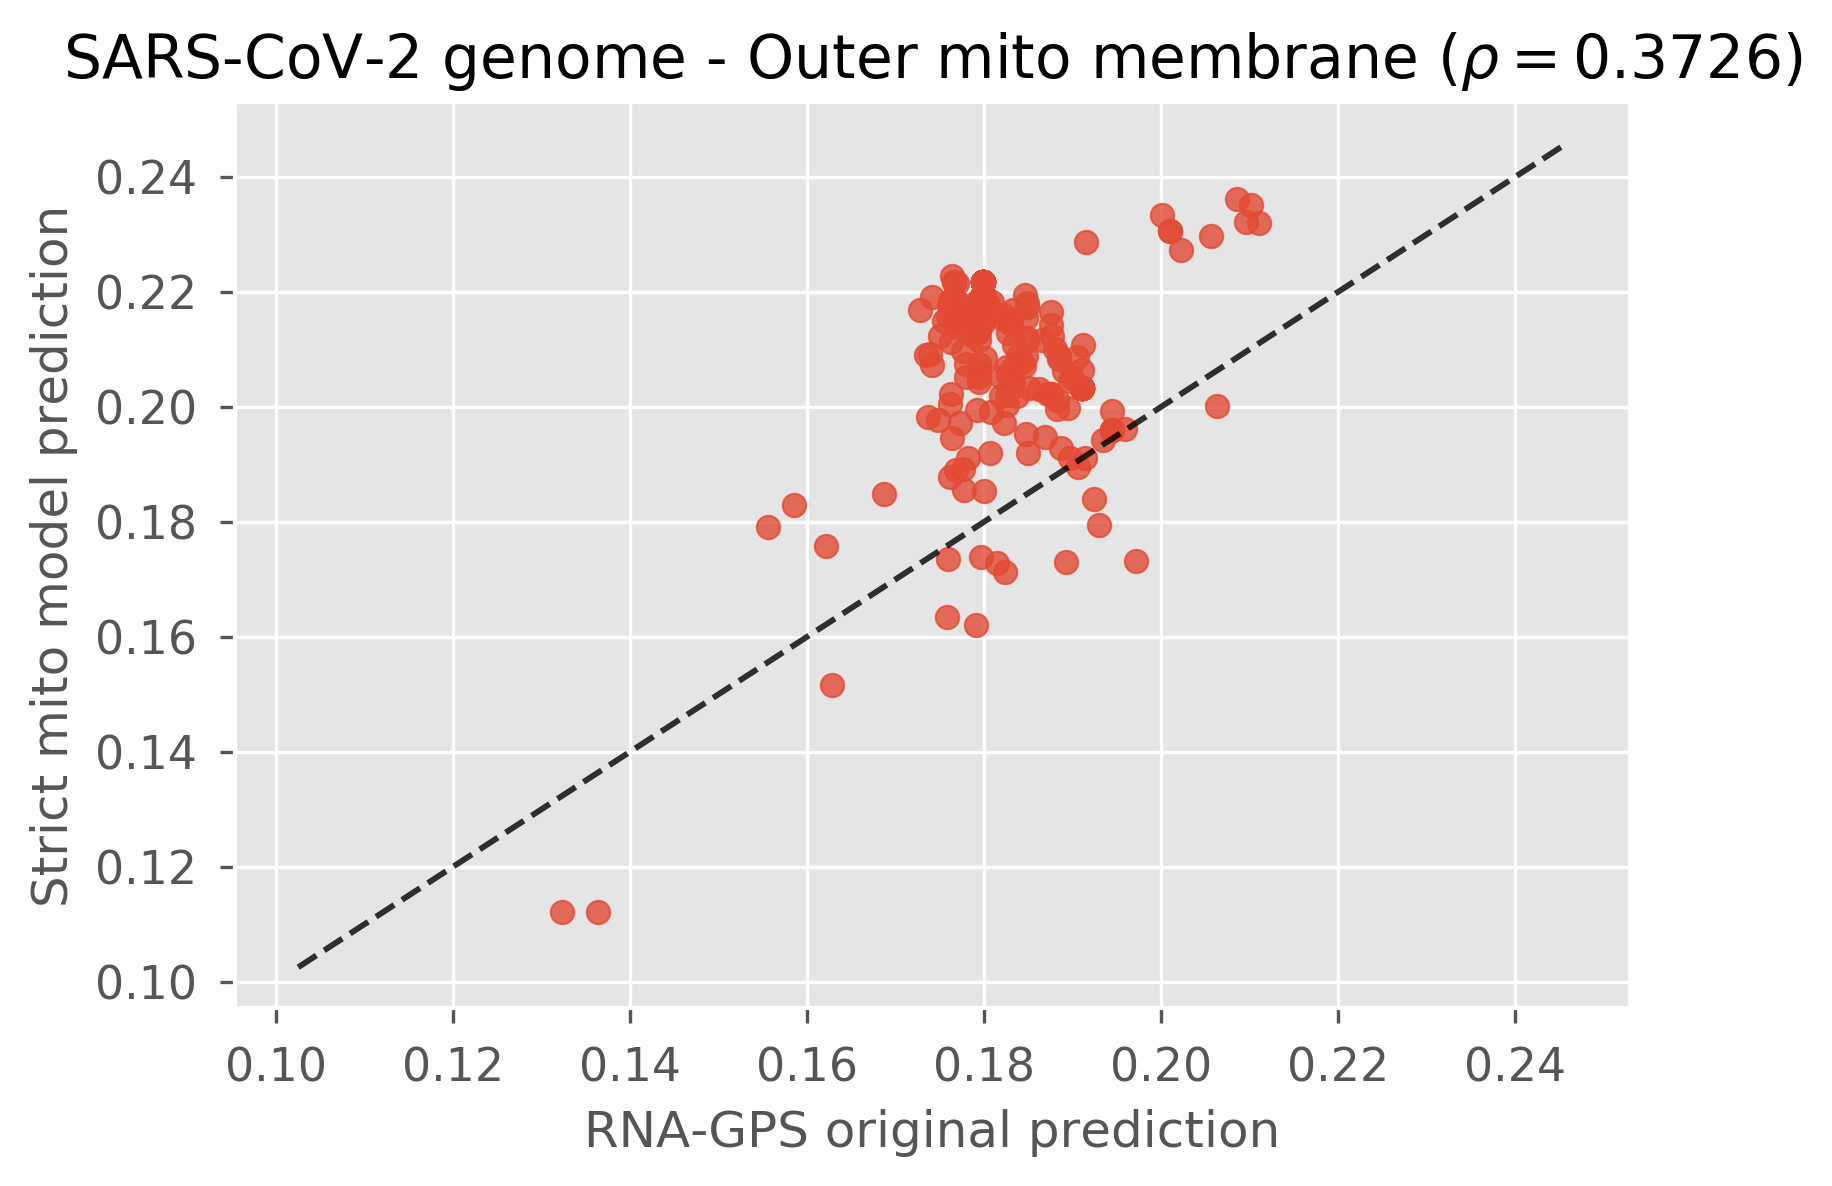

In [41]:
for localization in data_loader.LOCALIZATION_FULL_NAME_DICT.values():
    fig, ax = plt.subplots(dpi=300)
#     ax.plot((0, 1), (0, 1), linestyle='--', color='black', alpha=0.8)
    xvals = rnagps_covid_preds.loc[:, localization].values.flatten()
    yvals = strict_mito_covid_preds.loc[:, localization].values.flatten()
    pearson_r, pearson_p = scipy.stats.pearsonr(xvals, yvals)
    ax.scatter(  # Select based on *original* labels
        xvals,
        yvals,
        alpha=0.8,
    )
    xmin, xmax, ymin, ymax = ax.axis()
    r = (min(xmin, ymin), max(xmax, ymax))
    ax.plot(r, r, linestyle='--', color='black', alpha=0.8)
    ax.set(
        xlabel='RNA-GPS original prediction',
        ylabel='Strict mito model prediction',
        title=f"SARS-CoV-2 genome - {localization} ($\\rho = {pearson_r:.4f}$)"
    )
    fig.show()